<h1>Clasificacion supervisada Verbal Autopsy</h1>

<hr>

<h2>Presentación</h2>

El objetivo de este trabajo es realizar una clasificación supervisada usando diferentes técnicas de vectorización y diferentes clasificadores. Como técnicas de vectorización he utilizado Document Embedding y TF-IDF, las cuales se van a explicar más adelante, y como clasificadores, he utilizado DecisionTree como Baseline y MultiLayerPerceptron (MLP) como clasificador definitivo.

Para la clasificación, son importantes los valores que se utilizan para cada parámetro a la hora de lograr buenos resultados, y es por ello que he hecho un barrido de parámetros para intentar encontrar valores que mejoren los resultados.

He aprovechado parte del trabajo de Clustering para esta tarea, aunque he realizado varias modificaciones.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import nltk
from nltk.corpus import stopwords
import contractions
from nltk.stem import WordNetLemmatizer
import re
from nltk.stem import PorterStemmer
import seaborn as sb
from wordcloud import WordCloud
from imageio import imread

<hr>

<h2>Descripción y fuente</h2>

El conjunto de datos que he elegido es sobre Verbal Autopsy, método utilizado para intentar determinar la causa de muerte de un fallecido. Para
intentar averiguar la causa de muerte, se entrevistan a personas cercanas al fallecido recogiendo así la sintomatología o factores importantes que han
podido influir en dicha muerte.

Hay varios países en los que no se registran las muertes, ya sea por carencias del sistema de salud provocados por la extrema pobreza o por otros factores como la dictadura. Por lo tanto, en estos países sin registros de fallecimientos, el método de Verbal Autopsy es de crucial importancia para poder determinar o, por lo menos, tener una idea aproximada de la causa de muerte de sus ciudadanos.

Antes de empezar debemos crear un objeto a partir del archivo .csv que he escogido.

In [2]:
data = pd.read_csv("data/cleaned_PHMRC_VAI_redacted_free_text.train.csv")

Una vez creado aqui tenemos un pequeño ejemplo de lo que esta compuesto.

In [3]:
data.tail(5)

newid module   age  sex   site  \
5204   7120  Adult  42.0    1     UP   
5205   6101  Adult  14.0    2  Pemba   
5206   6455  Adult  80.0    2     UP   
5207   5026  Adult  70.0    1     UP   
5208   5326  Adult  30.0    1    Dar   

                                          open_response  \
5204  the deceased fell ill in the morning his breat...   
5205  the respondant expained that the decease death...   
5206  the deceased had been admitted to hospital whe...   
5207  the deceased had been suffering from breathing...   
5208  the deceased died because of being hitted by a...   

                          gs_text34  
5204                       Diabetes  
5205      Other Infectious Diseases  
5206                      Pneumonia  
5207  Other Cardiovascular Diseases  
5208                 Other Injuries

Primero valoraremos si alguna de las instancias tiene algun valor null.

In [4]:
data_null = data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5209 entries, 0 to 5208
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   newid          5209 non-null   int64  
 1   module         5209 non-null   object 
 2   age            5209 non-null   float64
 3   sex            5209 non-null   int64  
 4   site           5209 non-null   object 
 5   open_response  5209 non-null   object 
 6   gs_text34      5209 non-null   object 
dtypes: float64(1), int64(2), object(4)
memory usage: 285.0+ KB


No se aprecia ninguna entidad con valor null.

<h3>Representación gráfica</h3>

<BarContainer object of 48 artists>

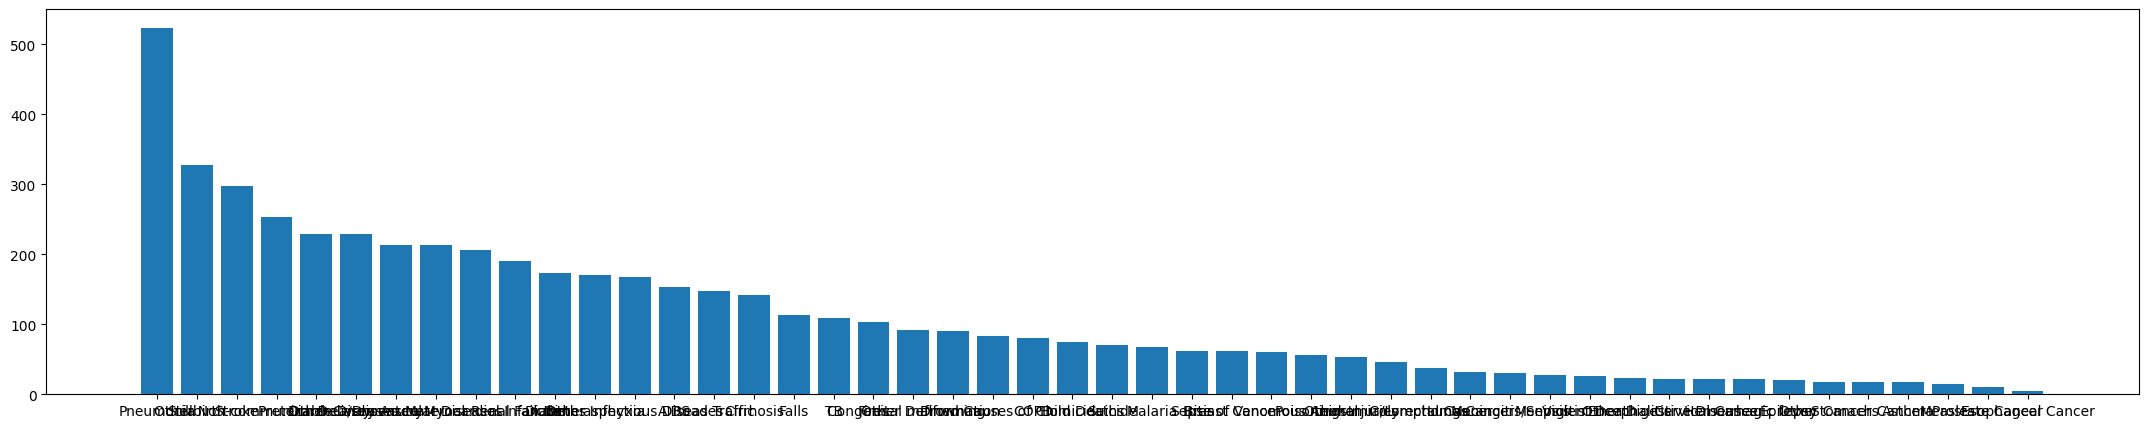

In [5]:
gs_text34 = data['gs_text34'].copy()
plt.rcParams['figure.figsize'] = [27, 5]
plt.bar(gs_text34.value_counts().index, gs_text34.value_counts())

Al haber 48 tipos de muertes en el archivo .csv no se llega a apreciar bien la informacion. Por lo tanto vamos a hacer el gráfico con 14 instancias para poder verlo más claro

<BarContainer object of 10 artists>

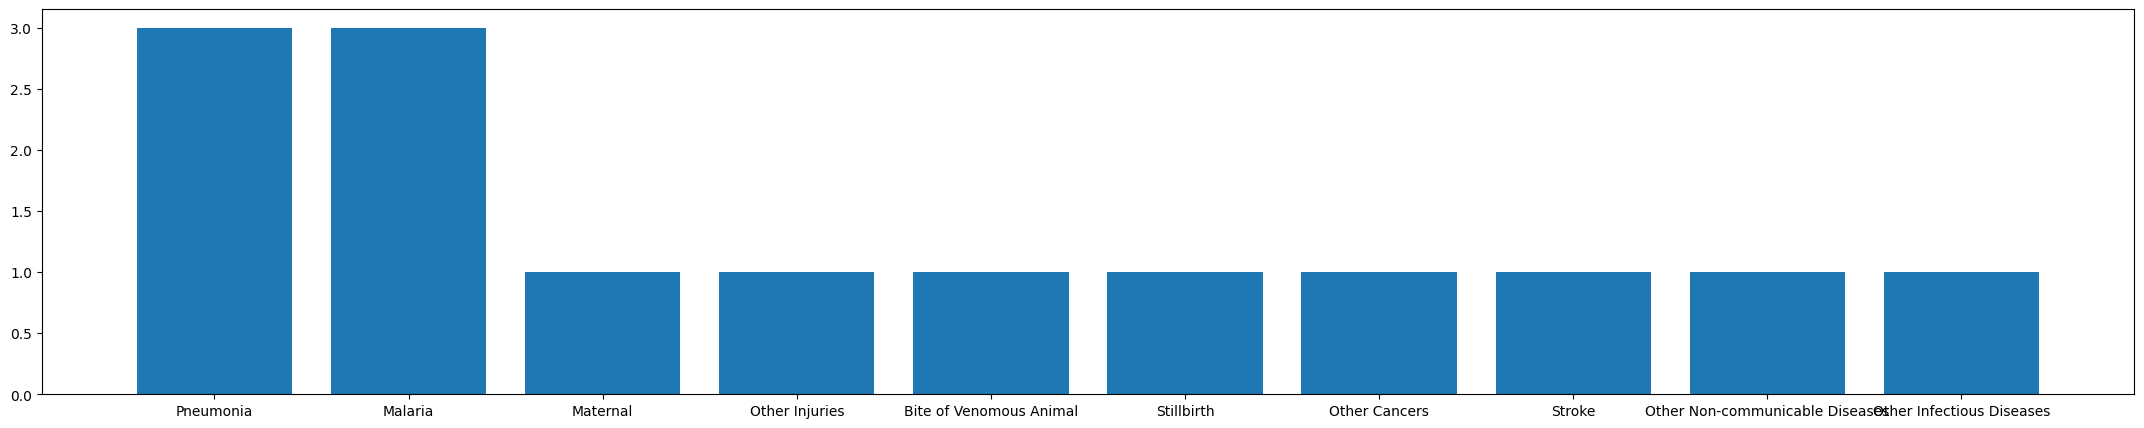

In [6]:
little_gs_text34 = gs_text34[0:14]
plt.bar(little_gs_text34.value_counts().index, little_gs_text34.value_counts())

Seleccionando solamente las 15 primera instancias del archivo .csv podemos apreciar que han habido 10 tipos diferentes de muerte y que solo dos de ellas se han repetido, en este caso 3 veces; Pneumonia y Malaria. 

<h3>Ver clases presentes y cadencia de cada una</h3>

In [7]:
print(data.groupby('gs_text34').size())

gs_text34
AIDS                                    154
Acute Myocardial Infarction             206
Asthma                                   17
Birth asphyxia                          171
Bite of Venomous Animal                  61
Breast Cancer                            62
COPD                                     80
Cervical Cancer                          22
Cirrhosis                               142
Colorectal Cancer                        37
Congenital malformation                  92
Diabetes                                174
Diarrhea/Dysentery                      229
Drowning                                 91
Encephalitis                             23
Epilepsy                                 20
Esophageal Cancer                         5
Falls                                   114
Fires                                   104
Hemorrhagic fever                        22
Homicide                                 74
Leukemia/Lymphomas                       46
Lung Cancer           

<h3>Agrupar clases en grupos más grandes</h3>

Hemos agrupado las clases para que haya menos, ya que con muchas clases la tarea de clasificación se complica y resulta más incómodo. La agrupación se ha hecho de acuerdo al fichero VA_ConsistentRelabelling.txt que se encuentra dentro de la carpeta data.

In [8]:
for i in range(len(data)):
    if data['gs_text34'][i] == 'TB':
        data['gs_text34'][i] = 'Certain infectious and Parasitic Diseases'  
    if data['gs_text34'][i] == 'Diarrhea/Dysentery':
        data['gs_text34'][i] = 'Certain infectious and Parasitic Diseases'
    if data['gs_text34'][i] == 'Other infectious diseases':
        data['gs_text34'][i] = 'Certain infectious and Parasitic Diseases'
    if data['gs_text34'][i] == 'AIDS':
        data['gs_text34'][i] = 'Certain infectious and Parasitic Diseases'
    if data['gs_text34'][i] == 'Sepsis':
        data['gs_text34'][i] = 'Certain infectious and Parasitic Diseases'
    if data['gs_text34'][i] == 'Meningitis':
        data['gs_text34'][i] = 'Certain infectious and Parasitic Diseases'
    if data['gs_text34'][i] == 'Meningitis/Sepsis':
        data['gs_text34'][i] = 'Certain infectious and Parasitic Diseases'
    if data['gs_text34'][i] == 'Malaria':
        data['gs_text34'][i] = 'Certain infectious and Parasitic Diseases'
    if data['gs_text34'][i] == 'Encephalitis':
        data['gs_text34'][i] = 'Certain infectious and Parasitic Diseases'
    if data['gs_text34'][i] == 'Measles':
        data['gs_text34'][i] = 'Certain infectious and Parasitic Diseases'
    if data['gs_text34'][i] == 'Hemorrhagic Fever':
        data['gs_text34'][i] = 'Certain infectious and Parasitic Diseases'
    if data['gs_text34'][i] == 'TB':
        data['gs_text34'][i] = 'Certain infectious and Parasitic Diseases'
    
    #----------------------------------------------------------------------------------
    
    if data['gs_text34'][i] == 'Leukemia/Lymphomas':
        data['gs_text34'][i] = 'Neoplasms'
    if data['gs_text34'][i] == 'Colorectal Cancer':
        data['gs_text34'][i] = 'Neoplasms'
    if data['gs_text34'][i] == 'Lung Cancer':
        data['gs_text34'][i] = 'Neoplasms'
    if data['gs_text34'][i] == 'Cervical Cancer':
        data['gs_text34'][i] = 'Neoplasms'
    if data['gs_text34'][i] == 'Breast Cancer':
        data['gs_text34'][i] = 'Neoplasms'
    if data['gs_text34'][i] == 'Stomach Cancer':
        data['gs_text34'][i] = 'Neoplasms'
    if data['gs_text34'][i] == 'Prostate Cancer':
        data['gs_text34'][i] = 'Neoplasms'
    if data['gs_text34'][i] == 'Esophageal Cancer':
        data['gs_text34'][i] = 'Neoplasms'
    if data['gs_text34'][i] == 'Other Cancers':
        data['gs_text34'][i] = 'Neoplasms'
        
    #----------------------------------------------------------------------------------

    if data['gs_text34'][i] == 'Diabetes':
        data['gs_text34'][i] = 'Endocrine, Nutritional and Metabolic Diseases'
    
    #----------------------------------------------------------------------------------

    if data['gs_text34'][i] == 'Epilepsy':
        data['gs_text34'][i] = 'Diseases of the Nervous System'
    
    #----------------------------------------------------------------------------------

    if data['gs_text34'][i] == 'Stroke':
        data['gs_text34'][i] = 'Diseases of the circulatory system'
    if data['gs_text34'][i] == 'Acute Myocardial Infarction':
        data['gs_text34'][i] = 'Diseases of the circulatory system'
    
    #----------------------------------------------------------------------------------
    
    if data['gs_text34'][i] == 'Pneumonia':
        data['gs_text34'][i] = 'Diseases of Respiratory System'
    if data['gs_text34'][i] == 'Asthma':
        data['gs_text34'][i] = 'Diseases of Respiratory System'
    if data['gs_text34'][i] == 'COPD':
        data['gs_text34'][i] = 'Diseases of Respiratory System'

    #----------------------------------------------------------------------------------

    if data['gs_text34'][i] == 'Cirrhosis':
        data['gs_text34'][i] = 'Diseases of the Digestive System'
    if data['gs_text34'][i] == 'Other Digestive Diseases':
        data['gs_text34'][i] = 'Diseases of the Digestive System'
    
    #----------------------------------------------------------------------------------

    if data['gs_text34'][i] == 'Renal Failure':
        data['gs_text34'][i] = 'Diseases of the Genitourinary System'
    
    #----------------------------------------------------------------------------------
    
    if data['gs_text34'][i] == 'Preterm Delivery':
        data['gs_text34'][i] = 'Pregnancy, childbirth and the puerperiu'
    if data['gs_text34'][i] == 'Stillbirth':
        data['gs_text34'][i] = 'Pregnancy, childbirth and the puerperiu'
    if data['gs_text34'][i] == 'Maternal':
        data['gs_text34'][i] = 'Pregnancy, childbirth and the puerperiu'
    if data['gs_text34'][i] == 'Birth Asphyxia':
        data['gs_text34'][i] = 'Pregnancy, childbirth and the puerperiu'
        
    #----------------------------------------------------------------------------------

    if data['gs_text34'][i] == 'Congenital Malformations':
        data['gs_text34'][i] = 'Congenital Malformations'
    
    #----------------------------------------------------------------------------------
    
    if data['gs_text34'][i] == 'Bite of Venomous Animal':
        data['gs_text34'][i] = 'Injury, Poisoning and External Causes'
    if data['gs_text34'][i] == 'Poisonings':
        data['gs_text34'][i] = 'Injury, Poisoning and External Causes'
        
    #----------------------------------------------------------------------------------
    
    if data['gs_text34'][i] == 'Road Traffic':
        data['gs_text34'][i] = 'External Causes of Morbidity and Mortality'
    if data['gs_text34'][i] == 'Falls':
        data['gs_text34'][i] = 'External Causes of Morbidity and Mortality'
    if data['gs_text34'][i] == 'Homicide':
        data['gs_text34'][i] = 'External Causes of Morbidity and Mortality'
    if data['gs_text34'][i] == 'Fires':
        data['gs_text34'][i] = 'External Causes of Morbidity and Mortality'
    if data['gs_text34'][i] == 'Drowning':
        data['gs_text34'][i] = 'External Causes of Morbidity and Mortality'
    if data['gs_text34'][i] == 'Suicide':
        data['gs_text34'][i] = 'External Causes of Morbidity and Mortality'
    if data['gs_text34'][i] == 'Violent Death':
        data['gs_text34'][i] = 'External Causes of Morbidity and Mortality'
    if data['gs_text34'][i] == 'Other Injuries':
        data['gs_text34'][i] = 'External Causes of Morbidity and Mortality'

/tmp/ipykernel_11330/2546714229.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['gs_text34'][i] = 'Diseases of Respiratory System'
/tmp/ipykernel_11330/2546714229.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['gs_text34'][i] = 'Pregnancy, childbirth and the puerperiu'
/tmp/ipykernel_11330/2546714229.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['gs_text34'][i] = 'External Causes of Morbidity and Morta

In [9]:
print(data.groupby('gs_text34').size())
print('________________________________________________________')
print('Numero de enfermedades: ' + str(len(np.unique(data['gs_text34']))))

gs_text34
Birth asphyxia                                   171
Certain infectious and Parasitic Diseases        716
Congenital malformation                           92
Diseases of Respiratory System                   621
Diseases of the Digestive System                 164
Diseases of the Genitourinary System             191
Diseases of the Nervous System                    20
Diseases of the circulatory system               504
Endocrine, Nutritional and Metabolic Diseases    174
External Causes of Morbidity and Mortality       681
Hemorrhagic fever                                 22
Injury, Poisoning and External Causes            117
Neoplasms                                        249
Other Cardiovascular Diseases                    213
Other Defined Causes of Child Deaths              83
Other Infectious Diseases                        168
Other Non-communicable Diseases                  253
Pregnancy, childbirth and the puerperiu          770
dtype: int64
_______________________

<h3>Quitar columnas que no den información</h3>

El id de cada instancia no nos da información para hacer la clasificación asi que la borramos.

In [10]:
data.drop("newid", axis=1, inplace=True)
data.head(5)

module   age  sex   site                                      open_response  \
0  Adult  65.0    1  Bohol  date he felt a lower back pain and had fever s...   
1  Child   0.0    2    Dar                    the caese of death is pneumonia   
2  Adult  23.0    2     AP  i took my wife to a private hospital for tubec...   
3  Adult  40.0    1     AP  he went to the work on sunday there were # iro...   
4  Adult  55.0    1     UP  the deceased had died due to a snake bite the ...   

                                    gs_text34  
0              Diseases of Respiratory System  
1              Diseases of Respiratory System  
2     Pregnancy, childbirth and the puerperiu  
3  External Causes of Morbidity and Mortality  
4       Injury, Poisoning and External Causes

<h3>Información de los datos numéricos.</h3>

/tmp/ipykernel_11330/391882538.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data.drop(['gs_text34'],1).hist()


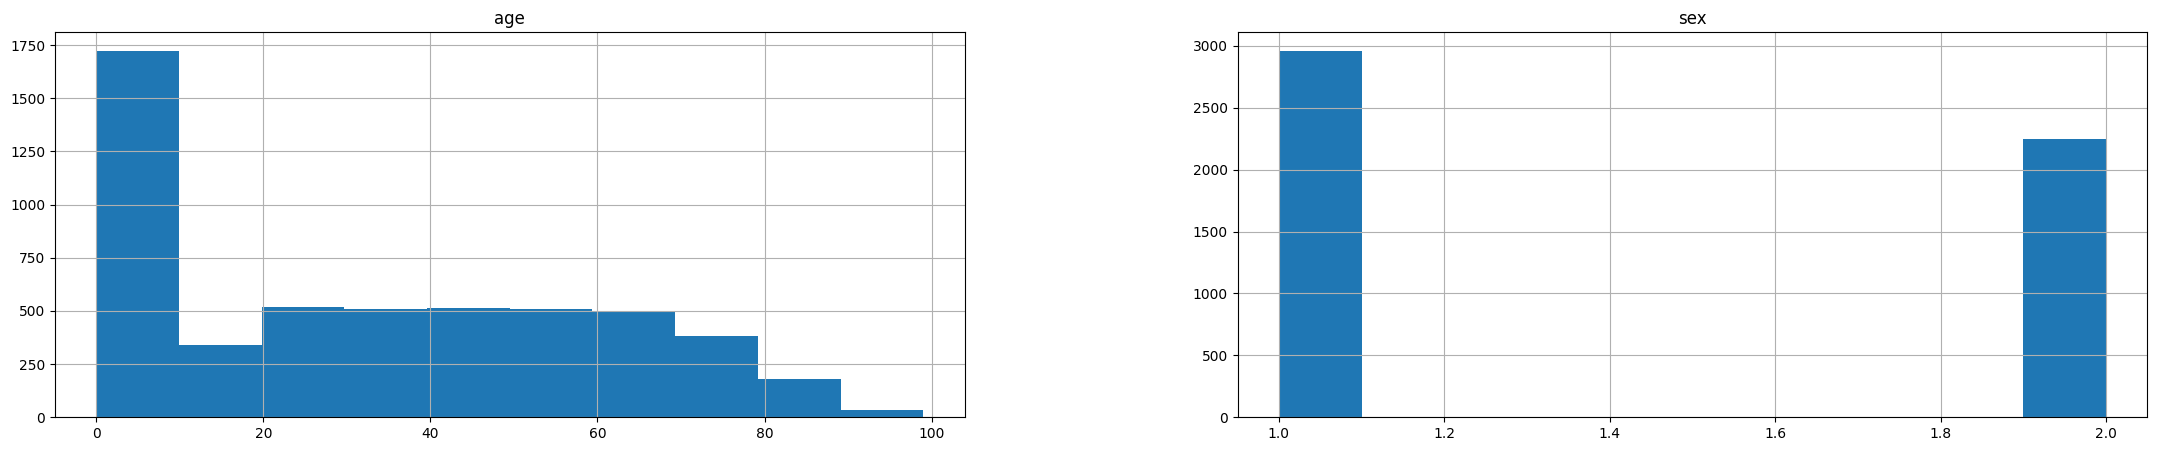

In [11]:
data.drop(['gs_text34'],1).hist()
plt.show()

In [12]:
data['gs_text34'].describe()

count                                        5209
unique                                         18
top       Pregnancy, childbirth and the puerperiu
freq                                          770
Name: gs_text34, dtype: object

<hr>

<h1>PreProcesamiento Train</h1>

El preprocesamiento de texto es un método para limpiar los datos de texto y dejarlos listos para alimentar el modelo. Los datos de texto contienen ruido en varias formas como emociones, puntuación, conjugaciones, etc. Cuando hablamos del lenguaje humano, hay diferentes formas de decir lo mismo, y este es el principal problema que tenemos que tratar, porque las máquinas no entienden las palabras, necesitan números, así que tenemos que convertir el texto en números de una manera eficiente.

Para ello hemos tenido que aplicar diferentes rutinas que transformen el texto base y lo preparen para poder vectorizarlo de la mejor forma posible.

<h3>0. Traducir a español</h3>

La intención de esta rutina es traducir cada una de las frases que recibimos. Con esto lo que buscamos es poder mostrar wordcloud-s y métricas de las palabras en castellano también. El problema reside en el coste de utilizar esta rutina y que el exceso de peticiones HTTP genera un error. En lugar de esto lo que hacemos para poder asignarle un cluster a una frase en español es traducir esa frase a ingles y clasifica dicha clase. En el aspecto funcional seria lo mismo con la diferencia que nos perdemos las métricas de las frases del conjunto de datos en español así como el wordcloud del mismo.

In [13]:
data_esp = data.copy()

data_esp.head(5)

module   age  sex   site                                      open_response  \
0  Adult  65.0    1  Bohol  date he felt a lower back pain and had fever s...   
1  Child   0.0    2    Dar                    the caese of death is pneumonia   
2  Adult  23.0    2     AP  i took my wife to a private hospital for tubec...   
3  Adult  40.0    1     AP  he went to the work on sunday there were # iro...   
4  Adult  55.0    1     UP  the deceased had died due to a snake bite the ...   

                                    gs_text34  
0              Diseases of Respiratory System  
1              Diseases of Respiratory System  
2     Pregnancy, childbirth and the puerperiu  
3  External Causes of Morbidity and Mortality  
4       Injury, Poisoning and External Causes

In [14]:
from time import sleep
import concurrent.futures
import goslate

executor = concurrent.futures.ThreadPoolExecutor(max_workers=1)
gs = goslate.Goslate(service_urls=['http://translate.google.de'], executor=executor)

def traducir_ing2esp(txt):
    return gs.translate(txt, 'es') 

def traducir_esp2ing(txt):
    return gs.translate(txt, 'en') 

In [15]:
#data_esp["open_response"] = data_esp["open_response"].head(5).apply(lambda txt: traducir_ing2esp(txt))
#data_esp.head(5)


<h2>1. Pasar a minúsculas el texto</h2>

Si el texto no esta completamente en minusculas o mayúsculas, no es fácil para una máquina interpretar las palabras porque las minúsculas y las mayúsculas son tratadas de forma diferente por la máquina. Por lo tanto, tenemos que hacer que el texto esté en el mismo formato y el formato más preferido es una minúscula para evitar tales problemas.

In [16]:
data["open_response"] = data["open_response"].str.lower()
data.head(5)

#data_esp["open_response"] = data_esp["open_response"].str.lower()
#data_esp.head(5)

module   age  sex   site                                      open_response  \
0  Adult  65.0    1  Bohol  date he felt a lower back pain and had fever s...   
1  Child   0.0    2    Dar                    the caese of death is pneumonia   
2  Adult  23.0    2     AP  i took my wife to a private hospital for tubec...   
3  Adult  40.0    1     AP  he went to the work on sunday there were # iro...   
4  Adult  55.0    1     UP  the deceased had died due to a snake bite the ...   

                                    gs_text34  
0              Diseases of Respiratory System  
1              Diseases of Respiratory System  
2     Pregnancy, childbirth and the puerperiu  
3  External Causes of Morbidity and Mortality  
4       Injury, Poisoning and External Causes

<h2>2. Quitar marcas de puntuación</h2>

Otra traba para que la maquina pueda interpretar el texto de forma adecuada son las marcas de puntuación. Esto se da por que las palabras que vayan precedidas o sucedidos por una marca de puntuación no serán interpretadas de las misma manera que las palabras que no lo vayan. Esto supondrá que no serán interpretas adecuadamente por la maquina.

In [17]:
def quitar_marcasPuntuacion(text:str):
    return text.translate(str.maketrans('', '', string.punctuation))

In [18]:
print(data["open_response"][45])

my mother suffered from fever continuously for # months she was treated in hospital where the doctor prescribed medicines but fever did not control later she was taken to hospital since the treatment was so expensive in the hospital the doctor advised us to take her to hospital but we did not take her to hospital but took her to hospital and admitted there since stains were present all over the body the doctors were firm to see the test results on the stains to proceed further on treatment by that time they were not specific to name the disease she was dead when the treatment was going on


In [19]:
data["open_response"] = data["open_response"].apply(lambda txt: quitar_marcasPuntuacion(txt))

#data_esp["open_response"] = data_esp["open_response"].apply(lambda txt: quitar_marcasPuntuacion(txt))


In [20]:
print(data["open_response"][45])

my mother suffered from fever continuously for  months she was treated in hospital where the doctor prescribed medicines but fever did not control later she was taken to hospital since the treatment was so expensive in the hospital the doctor advised us to take her to hospital but we did not take her to hospital but took her to hospital and admitted there since stains were present all over the body the doctors were firm to see the test results on the stains to proceed further on treatment by that time they were not specific to name the disease she was dead when the treatment was going on


<h2>3. Extender las contracciones</h2>

En inglés dependiendo del contexto para decir la misma frase se pueden o no utilizar contracciones. Esto de igual manera que en los anteriores casos genera discordancia en las frases en las que pone lo mismo pero utiliza un formalismo diferente para escribirlas. Es por ello que tenemos que utilizar esta rutina que expanda dichas contracciones y las devuelta a la forma sin contraer.

In [21]:
def extender_contracciones(text):    
    expanded_words = []   
    for word in text.split():
      # using contractions.fix to expand the shortened words
      expanded_words.append(contractions.fix(word))  

    return ' '.join(expanded_words)

In [22]:
cntrtn_text = "I've to go the toilet, I can't wait."
print(cntrtn_text)
print(extender_contracciones(cntrtn_text))

I've to go the toilet, I can't wait.
I have to go the toilet, I cannot wait.


In [23]:
data["open_response"] = data["open_response"].apply(lambda txt: extender_contracciones(txt))

<h2>4. Stemming</h2>

Stemming: El stemming consiste en quitar y reemplazar sufijos de la raíz de la palabra, mientras que la ya explicada lematización es un poco más compleja e implica hacer un análisis del vocabulario y su morfología para retornar la forma básica de la palabra. Es por ello que el uso de las dos a la vez no tiene demasiado sentido. En nuestro caso hemos decidido optar por la lematización.

In [24]:
#stemmer = PorterStemmer()

#def stem_palabras(text):
#    return " ".join([stemmer.stem(word) for word in text.split()])

In [25]:
#print(data["open_response"][0])

In [26]:
#data["open_response"] = data["open_response"].apply(lambda text: stem_palabras(text))

In [27]:
#print(data["open_response"][0])

<h2>5. Lematizacion</h2>

La lematización es un proceso lingüístico que consiste en, dada una forma flexionada hallar el lema correspondiente. El lema es la forma que por convenio se acepta como representante de todas las formas flexionadas de una misma palabra. 

De esta manera buscamos que las palabras flexionadas en singular / plural, tiempo verbal y formas comparativas / superlativas de adverbios y adjetivos coincidan en la misma palabra y sea entendido por la máquina como tal.

In [28]:
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('omw-1.4')

def lematizar_palabras(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

[nltk_data] Downloading package wordnet to /home/gortxut/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/gortxut/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [29]:
print(data["open_response"][0])

date he felt a lower back pain and had fever so we went to hospital here in place the doctor was suspecting arthritis he was ordered for x ray so we went to hospital lab results are all normal but suddenly the complained of difficulty in breathing the doctor said that he has pneumonia oxygen inhalation was started and still he was weak and his blood sugar was elevated and he died the ff day


In [30]:
data["open_response"] = data["open_response"].apply(lambda text: lematizar_palabras(text))

In [31]:
print(data["open_response"][0])

date he felt a lower back pain and had fever so we went to hospital here in place the doctor wa suspecting arthritis he wa ordered for x ray so we went to hospital lab result are all normal but suddenly the complained of difficulty in breathing the doctor said that he ha pneumonia oxygen inhalation wa started and still he wa weak and his blood sugar wa elevated and he died the ff day


<h2>6. Quitar las stopwords</h2>

Las palabras que generalmente se filtran antes de procesar un lenguaje natural se denominan stopwords. En realidad son las palabras más comunes en cualquier idioma (como artículos, preposiciones, pronombres, conjunciones, etc.) y no añaden mucha información al texto. Algunos ejemplos de stopword en inglés son "the", "a", "an", "so", "what".

Las stopword son abundantes en cualquier lengua humana. Al eliminar estas palabras, eliminamos la información de bajo nivel de nuestro texto para centrarnos más en la información importante. En otras palabras, podemos decir que la eliminación de estas palabras no tiene ninguna consecuencia negativa en el modelo que entrenamos para nuestra tarea.

La eliminación de las stopword reduce definitivamente el tamaño del conjunto de datos y, por tanto, el tiempo de entrenamiento debido al menor número de tokens implicados en el entrenamiento.

In [32]:
nltk.download('stopwords')
def quitar_stopwords(txt:str):
    return ' '.join([word for word in txt.split(' ') if word not in stopwords.words('english')])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gortxut/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
print(data["open_response"][1])

the caese of death is pneumonia


In [34]:
data["open_response"] = data["open_response"].apply(lambda txt: quitar_stopwords(txt))


In [35]:
print(data["open_response"][1])

caese death pneumonia


<h2>7. Quitar las palabras más usadas que no dan información útil</h2>

(Esta parte es nueva en comparación con el trabajo anterior de Clustering) 

Primero vemos cuales son las palabras más repetidas. Crearemos un fichero en la carpeta data_output llamado 'most-common-pre.csv' que nos mostrará las palabras más usadas.

In [36]:
from typing import Counter
import csv


cnt = Counter()

for text in data["open_response"].values:
    for word in text.split():
        cnt[word] += 1  

with open("data_output/most-common-pre.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(cnt.most_common(100))


<h3>WordCloud</h3>

Se han representado wordclouds de algunas clases (Neoplasms y Pregnancy, childbirth and the puerperiu). Una nube de palabras o nube de etiquetas es una representación visual de las palabras que conforman un texto, en donde el tamaño es mayor para las palabras que aparecen con más frecuencia. De esta manera sabremos en cada una de las enfermedades cuales son las palabras que más aparecen. Guardaremos los wordclouds de las dos clases (en data_graphics/wordclouds) antes y después de quitar palabras y veremos la diferencia.

/tmp/ipykernel_11330/3939646289.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mascara = imread('./images/maskHealth.png')


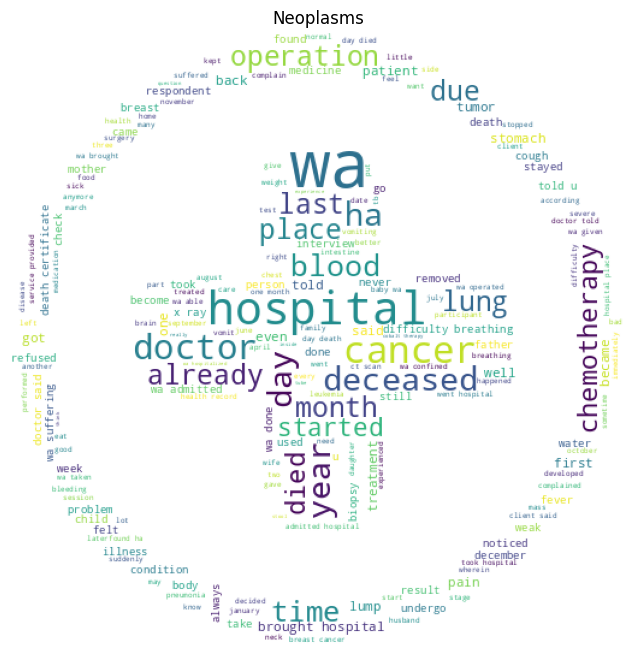

In [37]:
from wordcloud import WordCloud
from imageio import imread

neoplasms = data[data["gs_text34"]=="Neoplasms"]
neoplasms = neoplasms['open_response']

mascara = imread('./images/maskHealth.png')

neoplasmsWC = WordCloud(background_color='white',mask=mascara).generate(' '.join(neoplasms))
plt.figure(figsize=(11,8))
plt.imshow(neoplasmsWC)
plt.title("Neoplasms")
plt.axis("off")
plt.savefig("data_graphics/wordclouds/Neoplasms-pre.png")

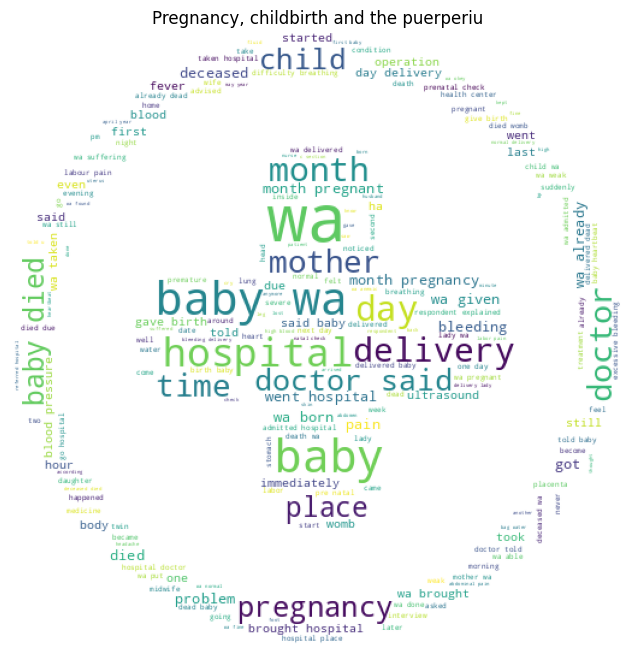

In [38]:
pcp = data[data["gs_text34"]=="Pregnancy, childbirth and the puerperiu"]
pcp = pcp['open_response']

pcpWC = WordCloud(background_color='white',mask=mascara).generate(' '.join(pcp))
plt.figure(figsize=(11,8))
plt.imshow(pcpWC)
plt.title("Pregnancy, childbirth and the puerperiu")
plt.axis("off")
plt.savefig("data_graphics/wordclouds/Pregnancy-pre.png")

Ahora eliminamos las palabras que no den información útil acerca de la causa de muerte. Para decidir que palabras eliminar, he mirado el fichero most-common-pre.csv de la carpeta data-output anteriormente guardado. Guardamos las palabras más usadas después de la eliminación en el fichero most-common-post.csv y guardamos el dataset nuevo en data_cleaned.csv (carpeta data_output)

In [39]:
for i in range(0, len(data["open_response"])):
    data["open_response"][i] = data["open_response"][i].replace(" wa ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" hospital ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" doctor ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" day ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" deceased ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" died ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" said ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" year ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" also ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" month ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" death ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" place ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" due ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" took ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" told ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" time ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" went ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" brought ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" ha ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" admitted ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" got ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" patient ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" problem ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" became ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" u ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" since ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" also ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" one ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" given ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" last ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" started ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" already ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" taken ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" d ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" gave ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" home ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" given ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" even ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" came ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" week ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" still ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" check ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" take ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" condition ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" health ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" first ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" later ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" delivery ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" used ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" go ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" hour ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" cannot ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" two ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" morning ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" found ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" client ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" get ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" ago ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" put ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" could ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" next ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" according ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" date ", " ")
    data["open_response"][i] = data["open_response"][i].replace(" a ", " ")


cnt = Counter()

for text in data["open_response"].values:
    for word in text.split():
        cnt[word] += 1  

with open("data_output/most-common-post.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(cnt.most_common(100))
data.to_csv("data_output/data_cleaned.csv")

/tmp/ipykernel_11330/54803886.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["open_response"][i] = data["open_response"][i].replace(" wa ", " ")
/tmp/ipykernel_11330/54803886.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["open_response"][i] = data["open_response"][i].replace(" hospital ", " ")
/tmp/ipykernel_11330/54803886.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["open_response"][i] = data["open_res

<h2>8. Quitar espacios extra</h2>

La mayoría de las veces los datos de texto contienen espacios adicionales o al realizar las técnicas de preprocesamiento anteriores se deja más de un espacio entre el texto, por lo que necesitamos controlar este problema.

In [40]:
def quitar_espaciosExtra(txt:str):
    return re.sub(' +', ' ', txt)

In [41]:
xtrSpc_text = "I've   to  go the toilet,  I can't   wait."
print(xtrSpc_text)
print(quitar_espaciosExtra(xtrSpc_text))

I've   to  go the toilet,  I can't   wait.
I've to go the toilet, I can't wait.


In [42]:
data["open_response"] = data["open_response"].apply(lambda text: quitar_espaciosExtra(text))

<h2>9. Pasar los atributos 'module' y 'site' a tipo numérico</h3>

(Esta parte es nueva comparado con el trabajo de Clustering)

Para hacer la clasificación necesitamos tener todos los atributos en forma numérica, asi que tenemos que convertir los datos no numéricos en numéricos.

In [43]:
from sklearn import preprocessing

data.head(5)
#creating labelEncoder
le = preprocessing.LabelEncoder()
# Converting string labels into numbers.
data["module"]=le.fit_transform(data["module"])
data["site"]=le.fit_transform(data["site"])
data.head(5)

module   age  sex  site                                      open_response  \
0       0  65.0    1     1  date felt lower back pain fever suspecting art...   
1       1   0.0    2     2                                    caese pneumonia   
2       0  23.0    2     0  took wife private tubectomy pregnant carrying ...   
3       0  40.0    1     0  went work sunday iron rod brother person hold ...   
4       0  55.0    1     5  deceased snake bite regained conscious gone co...   

                                    gs_text34  
0              Diseases of Respiratory System  
1              Diseases of Respiratory System  
2     Pregnancy, childbirth and the puerperiu  
3  External Causes of Morbidity and Mortality  
4       Injury, Poisoning and External Causes

<h3>Guardar preproceso</h3>

In [44]:
data.to_csv('data_output/preproceso.csv')

<hr>

Ahora volvemos a utilizar los wordclouds de los mismos atributos y podemos ver que las palabras son más significantes y hay más diferencia entre un atributo y otro. Esta vez las palabras son menos generales y más esepcificas. Los resultados se guardan en data_graphics/wordclouds.

/tmp/ipykernel_11330/1537736138.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mascara = imread('./images/maskHealth.png')


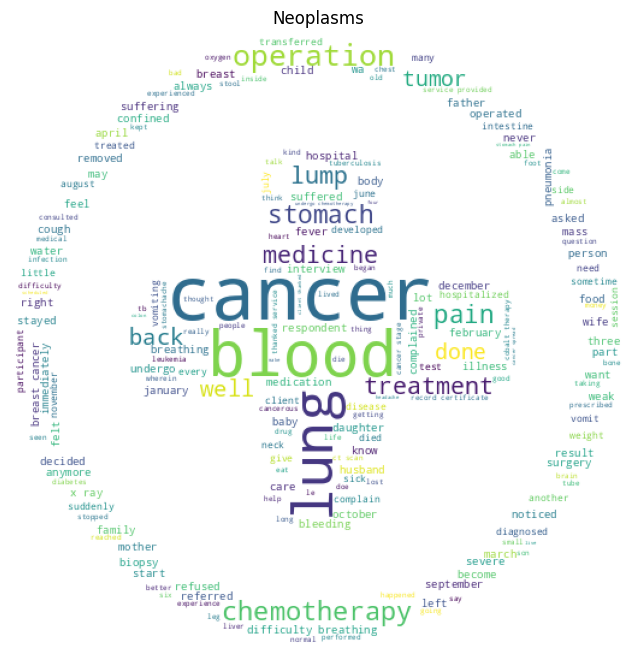

In [45]:
from wordcloud import WordCloud
from imageio import imread

neoplasms = data[data["gs_text34"]=="Neoplasms"]
neoplasms = neoplasms['open_response']

mascara = imread('./images/maskHealth.png')

neoplasmsWC = WordCloud(background_color='white',mask=mascara).generate(' '.join(neoplasms))
plt.figure(figsize=(11,8))
plt.imshow(neoplasmsWC)
plt.title("Neoplasms")
plt.axis("off")
plt.savefig("data_graphics/wordclouds/Neoplasms-post.png")

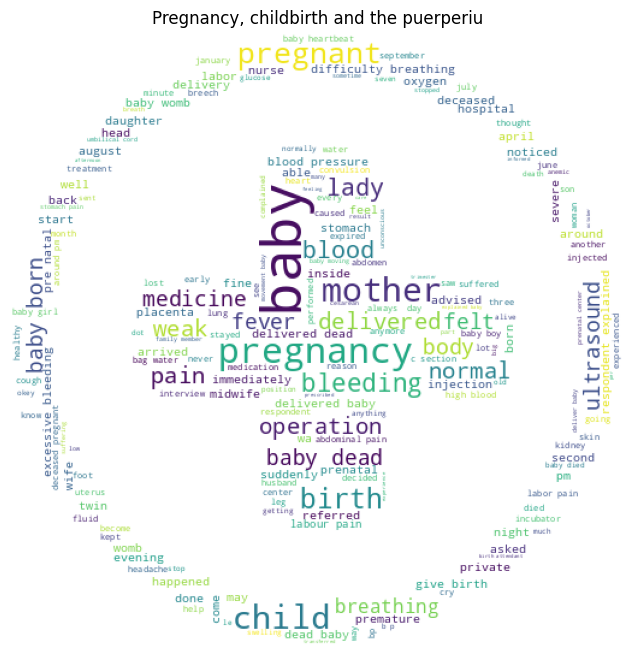

In [46]:
pcp = data[data["gs_text34"]=="Pregnancy, childbirth and the puerperiu"]
pcp = pcp['open_response']

pcpWC = WordCloud(background_color='white',mask=mascara).generate(' '.join(pcp))
plt.figure(figsize=(11,8))
plt.imshow(pcpWC)
plt.title("Pregnancy, childbirth and the puerperiu")
plt.axis("off")
plt.savefig("data_graphics/wordclouds/Pregnancy-post.png")

<hr>

<h2>Document embeding</h2>

Para poder realizar el clustering, necesitamos transformar la información de la que disponemos en forma de texto a números, y para ello hemos aplicado el document embedding.

Mediante esta técnica, se asigna un vector por instancia (el tamaño del vector es un parámetro alterable) y aquellos vectores que más cerca se encuentren entre sí serán los que tienen más en común. En nuestro caso concreto, la data que estamos vectorizando es la información acerca de la muerte de los fallecidos, por lo que cuanto más cerca esté un vector de otro, supondremos que la causa de muerte será más similar.

Para implementar el document embedding hemos utilizado Doc2Vec() de la librería Gensim. Dicha función tiene varios parámetros alterables, pero nosotros nos hemos centrado en 3 parámetros: vector_size, min_count y epochs.

 -Vector_size: el tamaño que van a tener los vectores creados. En nuestro caso hemos utilizado el valor 100.

 -Min_count: la frecuencia mínima para que una palabra del vocabulario se tenga en cuenta. Hemos utilizado el número 3.
 
 -Epochs: número de iteraciones sobre las instancias. El valor por defecto es 10 y nosotros hemos utilizado este mismo valor.


 Hemos dividido el proceso en varias partes. 

 Para empezar, creamos el modelo definiendo los parámetros previamente descritos y después, creamos el vocabulario a partir del atributo open_response de nuestras instancias. Debemos mencionar que Doc2Vec trabaja con información de tipo TaggedDocument, por lo que hemos tenido que adecuar nuestra data. 

In [47]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

data = pd.read_csv("data_output/preproceso.csv")

data_td = [TaggedDocument(d, [i]) for i, d in enumerate(data['open_response'])]

Acto seguido, entrenamos el modelo con el vocabulario ya creado.

In [48]:
model = Doc2Vec(vector_size=100, min_count=3, epochs=10) #crear el modelo
model.build_vocab(data_td) #crear el diccionario del modelo a partir del atributo 'open_response' de nuestras instancias
model.train(data_td, total_examples=model.corpus_count, epochs=model.epochs) #entrenar el modelo

Para finalizar, inferimos los vectores por cada instancia y los guardamos en un DataFrame y seguidamente en un fichero (data_output/doc_embedding.csv) para tener los datos preparados para la próxima representación gráfica. Además, guardamos los resultados del doc embedding en un fichero csv (data_output/post-DE.csv).
Además, a diferencia del anterior trabajo de Clustering, aquí tenemos en cuenta los demás atributos a la hora de la clasificación, así que concatenamos el doc embedding con los demás atributos

In [49]:
tagged_df = pd.Series( (v[0] for v in data_td))
data_de = pd.DataFrame(columns=list(range(100)), index=list(range(len(data))))

for i in range(data.shape[0]):
    data_de.loc[i] = model.infer_vector(tagged_df[i].split(" "))

data_de.to_csv('data_output/doc_embeding.csv')

dataPostDE = pd.concat([data, data_de], axis=1)
dataPostDE.drop("open_response", axis=1, inplace=True)
dataPostDE.drop("Unnamed: 0", axis=1, inplace=True)
dataPostDE.to_csv('data_output/post-DE.csv')
dataPostDE.head(5)

module   age  sex  site                                   gs_text34  \
0       0  65.0    1     1              Diseases of Respiratory System   
1       1   0.0    2     2              Diseases of Respiratory System   
2       0  23.0    2     0     Pregnancy, childbirth and the puerperiu   
3       0  40.0    1     0  External Causes of Morbidity and Mortality   
4       0  55.0    1     5       Injury, Poisoning and External Causes   

          0         1         2         3         4  ...        90        91  \
0 -0.009897  0.028545 -0.041756  0.002625  0.004499  ...  0.089781  0.048339   
1  -0.00323 -0.002374  0.002784 -0.003757  0.003466  ... -0.002306 -0.003788   
2 -0.002273  0.001297 -0.004384  0.001718 -0.001345  ...  0.000734  0.004244   
3 -0.004484  0.003647 -0.001822  0.003765 -0.002225  ...  0.002299 -0.003485   
4 -0.001728  0.000415  -0.00365  0.004844 -0.000076  ... -0.000374  0.002479   

         92        93        94        95        96        97        98  \
0  0.023894  0.051535  0.015435 -0.039349  0.000599  0.056478  0.031298   
1 -0.004473 -0.001159  0.004704  0.004601  0.001901  0.004747  0.001315   
2  -0.00414  0.000265  0.001126 -0.003504  0.001383 -0.002731  0.002618   
3  0.001695 -0.004347  0.000317 -0.003833  0.000067  -0.00044  0.001032   
4 -0.000898 -0.001221 -0.001685 -0.000254 -0.001127  0.000313 -0.004816   

         99  
0  0.038616  
1  0.002645  
2   0.00088  
3  0.003792  
4 -0.002907  

[5 rows x 105 columns]

<hr>

<h2>Representacion grafica de Doc Embedding</h2>

<h3>TSNE</h3>

Después de aplicar el document embedding, representamos el conjunto de datos gráficamente para poder apreciar donde se coloca cada instancia al vectorizarla. Pero antes de hacer los gráficos, tenemos que reducir las dimensiones de los vectores, ya que al utilizar la técnica del doc embedding, definimos un vector_size que no nos permite representar la información gráficamente. 

Para conseguir dicha reducción de dimensiones, hemos utilizado los métodos TSNE y PCA, los cuales intentan minimizar la pérdida de información al reducir las dimensiones. Sin embargo, en nuestro caso pasamos de 100 dimensiones a 3 y a 2, por lo que la pérdida de información es notoria y es posible que la representación gráfica no sea del todo fiel a la realidad. 

En la figura se puede ver el gráfico al aplicar TSNE con 3 dimensiones y en la figura \ref{fig3 se aprecian 3 gráficos en 2 dimensiones. En el primero se utiliza PCA, en el segundo TSNE y en el último se utilizan los dos; primero se aplica PCA para reducir las dimensiones a 50 y después se utiliza TSNE para conseguir 2 dimensiones. El color asignado a cada instancia en los gráficos representa la clase a la que pertenece.

In [50]:
from sklearn.manifold import TSNE

data = pd.read_csv("data_output/doc_embeding.csv")

tsne = TSNE(n_components=3, verbose=1, perplexity=20, n_iter=250)
tsne_results = tsne.fit_transform(data)
tsne_results

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 5209 samples in 0.001s...
[t-SNE] Computed neighbors for 5209 samples in 0.105s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5209
[t-SNE] Computed conditional probabilities for sample 2000 / 5209
[t-SNE] Computed conditional probabilities for sample 3000 / 5209
[t-SNE] Computed conditional probabilities for sample 4000 / 5209
[t-SNE] Computed conditional probabilities for sample 5000 / 5209
[t-SNE] Computed conditional probabilities for sample 5209 / 5209
[t-SNE] Mean sigma: 7.128109
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.399220
[t-SNE] KL divergence after 251 iterations: 179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953514382464234321326889464182768467546703537516986049910576551282076245490090389328944075868508455133942304583236903222948165808559332123348274797826204144723168738177180919299881250404026184124858368.00

array([[-10.756626  ,   0.969435  ,  -0.30891842],
       [-10.75664   ,   0.96920156,  -0.3083789 ],
       [-10.758349  ,   0.96888995,  -0.30848345],
       ...,
       [ 11.092786  ,  -0.7146146 ,  -0.49559715],
       [ 11.093105  ,  -0.7160484 ,  -0.4937617 ],
       [ 11.097197  ,  -0.716732  ,  -0.49479455]], dtype=float32)

In [51]:
label = pd.read_csv("data_output/preproceso.csv")
label = label['gs_text34']

data['tsne-one'] = tsne_results[:,0]
data['tsne-two'] = tsne_results[:,1]
data['tsne-three'] = tsne_results[:,2]
data['gs_text34'] = label
data_tsn = data.filter(['tsne-one', 'tsne-two','tsne-three','gs_text34'])
data_tsn.to_csv('data_graphics/doc2vec/data_tsne.csv')
data_tsn

tsne-one  tsne-two  tsne-three  \
0    -10.756626  0.969435   -0.308918   
1    -10.756640  0.969202   -0.308379   
2    -10.758349  0.968890   -0.308483   
3    -10.758360  0.968527   -0.308307   
4    -10.760778  0.967977   -0.310016   
...         ...       ...         ...   
5204  11.089084 -0.714497   -0.492139   
5205  11.086656 -0.716383   -0.492801   
5206  11.092786 -0.714615   -0.495597   
5207  11.093105 -0.716048   -0.493762   
5208  11.097197 -0.716732   -0.494795   

                                          gs_text34  
0                    Diseases of Respiratory System  
1                    Diseases of Respiratory System  
2           Pregnancy, childbirth and the puerperiu  
3        External Causes of Morbidity and Mortality  
4             Injury, Poisoning and External Causes  
...                                             ...  
5204  Endocrine, Nutritional and Metabolic Diseases  
5205                      Other Infectious Diseases  
5206                 Diseases of Respiratory System  
5207                  Other Cardiovascular Diseases  
5208     External Causes of Morbidity and Mortality  

[5209 rows x 4 columns]

In [52]:
import plotly.express as px

pca_3d = px.scatter_3d(data_tsn, x='tsne-one', y='tsne-two', z='tsne-three', color='gs_text34')
pca_3d.show()

<h3>PCA</h3>

https://builtin.com/data-science/tsne-python

In [53]:
from sklearn.decomposition import PCA

data = pd.read_csv("data_output/doc_embeding.csv")

pca = PCA(n_components=3)
pca_result = pca.fit_transform(data)
pca_result

array([[-2.60400000e+03,  4.44786242e-01,  2.50768078e-02],
       [-2.60300000e+03, -3.03237552e-02,  3.39958918e-03],
       [-2.60200000e+03, -3.65668204e-02,  3.57503471e-03],
       ...,
       [ 2.60200000e+03, -3.85817063e-02,  1.48759838e-03],
       [ 2.60300000e+03, -3.87838110e-02,  5.01639587e-03],
       [ 2.60400000e+03, -3.73586326e-02, -1.09465574e-03]])

In [54]:
label = pd.read_csv("data_output/preproceso.csv")
label = label['gs_text34']

data['pca-one'] = pca_result[:,0]
data['pca-two'] = pca_result[:,1]
data['pca-three'] = pca_result[:,2]
data['gs_text34'] = label

data_pca = data.filter(['pca-one', 'pca-two','pca-three','gs_text34'])
data_pca.to_csv('data_graphics/doc2vec/data_pca.csv')

data_pca

pca-one   pca-two  pca-three  \
0     -2604.0  0.444786   0.025077   
1     -2603.0 -0.030324   0.003400   
2     -2602.0 -0.036567   0.003575   
3     -2601.0 -0.029964   0.003915   
4     -2600.0 -0.034645   0.001877   
...       ...       ...        ...   
5204   2600.0 -0.036718   0.005755   
5205   2601.0 -0.037240   0.000088   
5206   2602.0 -0.038582   0.001488   
5207   2603.0 -0.038784   0.005016   
5208   2604.0 -0.037359  -0.001095   

                                          gs_text34  
0                    Diseases of Respiratory System  
1                    Diseases of Respiratory System  
2           Pregnancy, childbirth and the puerperiu  
3        External Causes of Morbidity and Mortality  
4             Injury, Poisoning and External Causes  
...                                             ...  
5204  Endocrine, Nutritional and Metabolic Diseases  
5205                      Other Infectious Diseases  
5206                 Diseases of Respiratory System  
5207                  Other Cardiovascular Diseases  
5208     External Causes of Morbidity and Mortality  

[5209 rows x 4 columns]

In [55]:
import plotly.express as px

pca_3d = px.scatter_3d(data_pca, x='pca-one', y='pca-two', z='pca-three', color='gs_text34')
pca_3d.show()


<h3>TSNE - PCA50</h3>

In [56]:
data = pd.read_csv("data_output/doc_embeding.csv")

pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(data)

In [57]:
tsne = TSNE(n_components=3, verbose=0, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result_50)
tsne_pca_results

array([[-11.853948  ,  -3.9793096 ,  -0.42691568],
       [-11.852262  ,  -3.974936  ,  -0.42550814],
       [-11.85047   ,  -3.9702797 ,  -0.42401463],
       ...,
       [ 12.737756  ,   2.0652592 ,   2.5023048 ],
       [ 12.7409115 ,   2.067657  ,   2.5056798 ],
       [ 12.743874  ,   2.069905  ,   2.5088513 ]], dtype=float32)

In [58]:
label = pd.read_csv("data_output/preproceso.csv")
label = label['gs_text34']

data['tsne-pca50-one'] = tsne_pca_results[:,0]
data['tsne-pca50-two'] = tsne_pca_results[:,1]
data['tsne-pca50-three'] = tsne_pca_results[:,2]
data['gs_text34'] = label

data_tsne_pca = data.filter(['tsne-pca50-one', 'tsne-pca50-two','tsne-pca50-three','gs_text34'])
data_tsne_pca.to_csv('data_graphics/doc2vec/data_tsne_pca.csv')

data_tsne_pca

tsne-pca50-one  tsne-pca50-two  tsne-pca50-three  \
0         -11.853948       -3.979310         -0.426916   
1         -11.852262       -3.974936         -0.425508   
2         -11.850470       -3.970280         -0.424015   
3         -11.848626       -3.965492         -0.422479   
4         -11.846596       -3.960240         -0.420799   
...              ...             ...               ...   
5204       12.730829        2.059995          2.494903   
5205       12.734392        2.062703          2.498712   
5206       12.737756        2.065259          2.502305   
5207       12.740911        2.067657          2.505680   
5208       12.743874        2.069905          2.508851   

                                          gs_text34  
0                    Diseases of Respiratory System  
1                    Diseases of Respiratory System  
2           Pregnancy, childbirth and the puerperiu  
3        External Causes of Morbidity and Mortality  
4             Injury, Poisoning and External Causes  
...                                             ...  
5204  Endocrine, Nutritional and Metabolic Diseases  
5205                      Other Infectious Diseases  
5206                 Diseases of Respiratory System  
5207                  Other Cardiovascular Diseases  
5208     External Causes of Morbidity and Mortality  

[5209 rows x 4 columns]

In [59]:
tsne_pca_3d = px.scatter_3d(data_tsne_pca, x='tsne-pca50-one', y='tsne-pca50-two', z='tsne-pca50-three', color='gs_text34')
tsne_pca_3d.show()

<h3>Comparacion 2D</h3>

<AxesSubplot: xlabel='tsne-pca50-one', ylabel='tsne-pca50-two'>

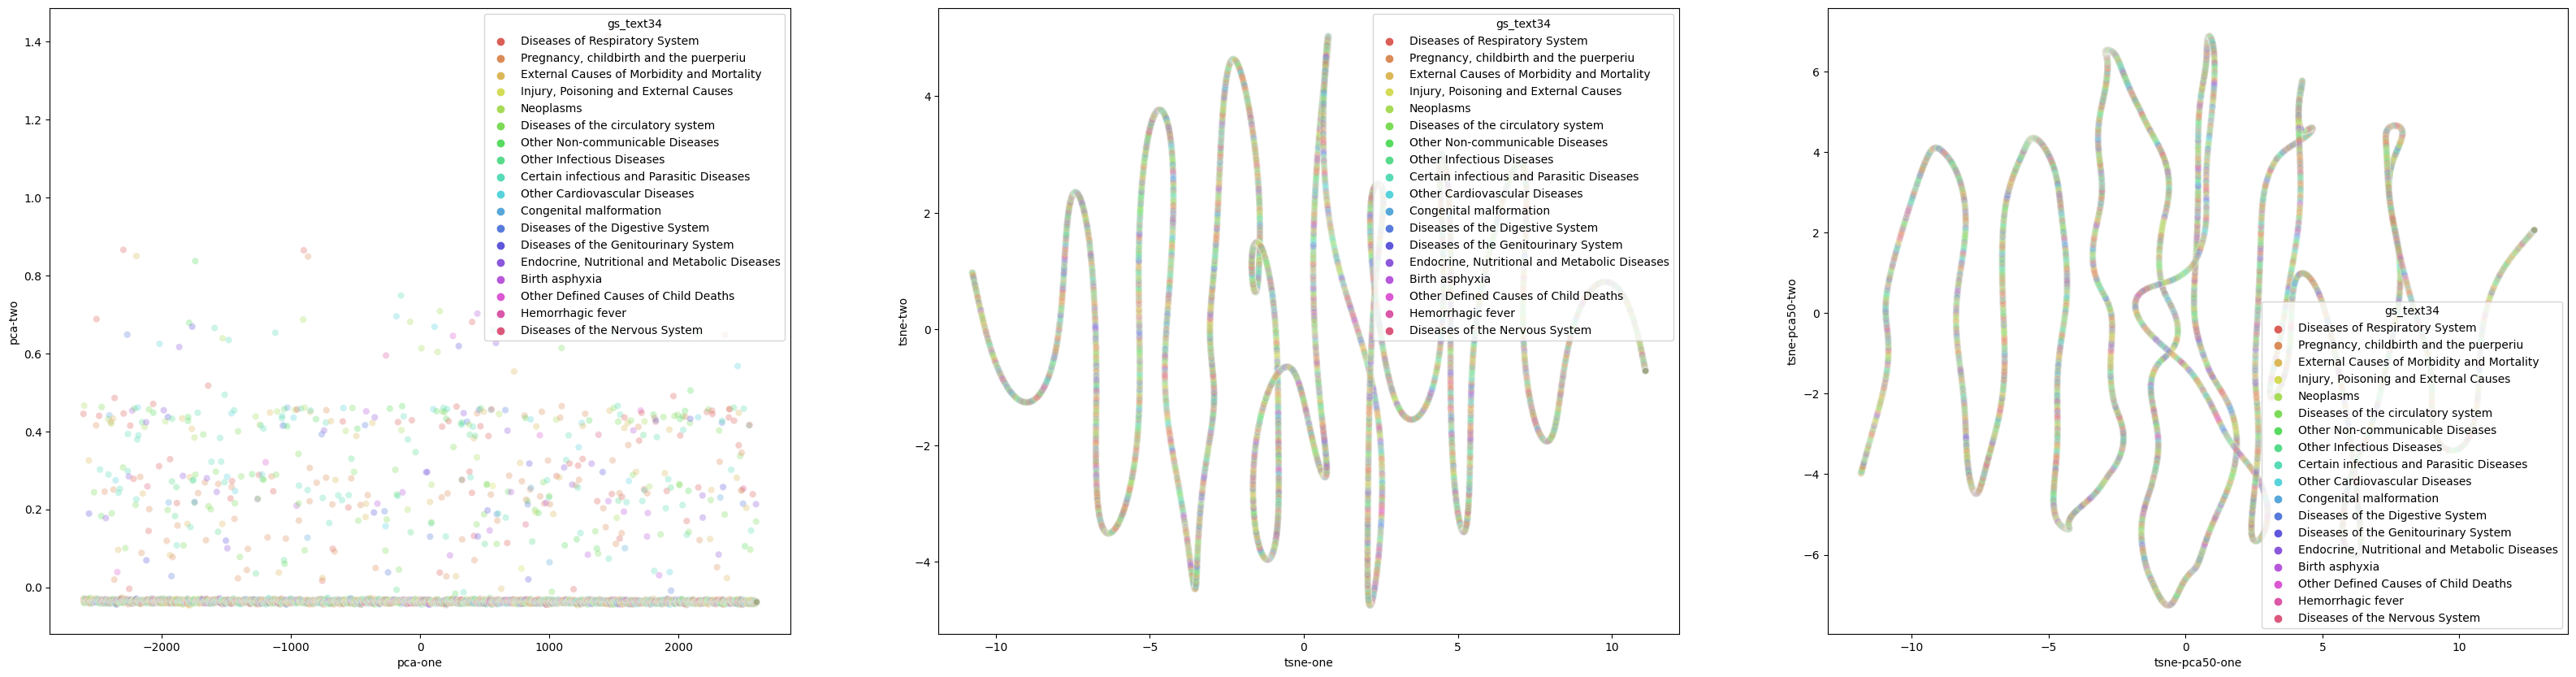

In [60]:
import seaborn as sns

plt.figure(figsize=(40,10))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 1)
ax3 = plt.subplot(1, 3, 1)

sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="gs_text34",
    palette=sns.color_palette("hls", 18),
    data=data_pca,
    legend="full",
    alpha=0.3,
    ax=ax1
)

ax2 = plt.subplot(1, 3, 2)
sns.scatterplot(
    x="tsne-one", y="tsne-two",
    hue="gs_text34",
    palette=sns.color_palette("hls", 18),
    data=data_tsn,
    legend="full",
    alpha=0.3,
    ax=ax2
)

ax3 = plt.subplot(1, 3, 3)
sns.scatterplot(
    x="tsne-pca50-one", y="tsne-pca50-two",
    hue="gs_text34",
    palette=sns.color_palette("hls", 18),
    data=data_tsne_pca,
    legend="full",
    alpha=0.3,
    ax=ax3
)

<hr>

A PARTIR DE AQUI TODO ES NUEVO EN COMPARACION AL TRABAJO DE CLUSTERING

<h2>TF-IDF</h2>

Además del doc2vec, se nos pide otro método de vectorización. Yo he utilizado el TF-IDF, método que asigna un valor a cada palabra de un documento dependiendo de como de relevante es.

Solo he utilizado un parámetro, min_df=3, que determina el número de apariciones mínimas de una palabra para que se tenga en cuenta. No he utilizado más parametros porque muchos hacen referencia al preproceso, y nosotros lo hemos hecho previamente.

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer

data = pd.read_csv("data_output/preproceso.csv")
data_or = data["open_response"]

vectorizer = TfidfVectorizer(min_df=3)
X = vectorizer.fit_transform(data_or)
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df.to_csv("data_output/tf-idf.csv")


Después de guardar el resultado del TF-IDF, concatenamos este resultado con los demás atributos y guardamos el dataset post TF-IDF en data_output/post-TFIDF.csv.

In [62]:
dataPostTF = pd.concat([data, tfidf_df], axis=1)
dataPostTF.drop("open_response", axis=1, inplace=True)
dataPostTF.drop("Unnamed: 0", axis=1, inplace=True)
dataPostTF.to_csv('data_output/post-TFIDF.csv')
dataPostTF.head(5)

module   age  sex  site                                   gs_text34   3d  \
0       0  65.0    1     1              Diseases of Respiratory System  0.0   
1       1   0.0    2     2              Diseases of Respiratory System  0.0   
2       0  23.0    2     0     Pregnancy, childbirth and the puerperiu  0.0   
3       0  40.0    1     0  External Causes of Morbidity and Mortality  0.0   
4       0  55.0    1     5       Injury, Poisoning and External Causes  0.0   

   abdomen  abdominal  ability  ablaze  ...  year  yellow  yellowish  yes  \
0      0.0        0.0      0.0     0.0  ...   0.0     0.0        0.0  0.0   
1      0.0        0.0      0.0     0.0  ...   0.0     0.0        0.0  0.0   
2      0.0        0.0      0.0     0.0  ...   0.0     0.0        0.0  0.0   
3      0.0        0.0      0.0     0.0  ...   0.0     0.0        0.0  0.0   
4      0.0        0.0      0.0     0.0  ...   0.0     0.0        0.0  0.0   

   yet  young  younger  youngest   yr  zero  
0  0.0    0.0      0.0       0.0  0.0   0.0  
1  0.0    0.0      0.0       0.0  0.0   0.0  
2  0.0    0.0      0.0       0.0  0.0   0.0  
3  0.0    0.0      0.0       0.0  0.0   0.0  
4  0.0    0.0      0.0       0.0  0.0   0.0  

[5 rows x 3558 columns]

<hr>

<h2>Separar la clase y los demás atributos para Hold-Out</h2>

Antes de poder hacer hold-out debemos separar el train y el test, y antes de hacer esta separación, tenemos que separar la clase de los demás atributos.

Lo haremos con los datos post doc2vec y post TF-IDF

<h3>Utilizando doc-embedding</h3>

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

dataPostDE = pd.read_csv("data_output/post-DE.csv")
dataPostDE.drop("Unnamed: 0", axis=1, inplace=True)
dataPostDE.drop("gs_text34", axis=1, inplace=True)
dataPostDE.head(5)

module   age  sex  site         0         1         2         3         4  \
0       0  65.0    1     1 -0.009897  0.028545 -0.041756  0.002625  0.004499   
1       1   0.0    2     2 -0.003230 -0.002374  0.002784 -0.003757  0.003466   
2       0  23.0    2     0 -0.002273  0.001297 -0.004384  0.001718 -0.001345   
3       0  40.0    1     0 -0.004484  0.003647 -0.001822  0.003765 -0.002225   
4       0  55.0    1     5 -0.001728  0.000415 -0.003650  0.004844 -0.000076   

          5  ...        90        91        92        93        94        95  \
0  0.004607  ...  0.089781  0.048339  0.023894  0.051535  0.015435 -0.039349   
1  0.000125  ... -0.002306 -0.003788 -0.004473 -0.001159  0.004704  0.004601   
2  0.000080  ...  0.000734  0.004244 -0.004140  0.000265  0.001126 -0.003504   
3  0.000391  ...  0.002299 -0.003485  0.001695 -0.004347  0.000317 -0.003833   
4 -0.003778  ... -0.000374  0.002479 -0.000898 -0.001221 -0.001685 -0.000254   

         96        97        98        99  
0  0.000599  0.056478  0.031298  0.038616  
1  0.001901  0.004747  0.001315  0.002645  
2  0.001383 -0.002731  0.002618  0.000880  
3  0.000067 -0.000440  0.001032  0.003792  
4 -0.001127  0.000313 -0.004816 -0.002907  

[5 rows x 104 columns]

In [64]:
labelsDE = pd.read_csv("data_output/post-DE.csv")["gs_text34"]
labelsDE.head(5)

0                Diseases of Respiratory System
1                Diseases of Respiratory System
2       Pregnancy, childbirth and the puerperiu
3    External Causes of Morbidity and Mortality
4         Injury, Poisoning and External Causes
Name: gs_text34, dtype: object

<h3>Utilizando TF-IDF</h3>

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

dataPostTF = pd.read_csv("data_output/post-TFIDF.csv")
dataPostTF.drop("Unnamed: 0", axis=1, inplace=True)
dataPostTF.drop("gs_text34", axis=1, inplace=True)
dataPostTF.head(5)



module   age  sex  site   3d  abdomen  abdominal  ability  ablaze  able  \
0       0  65.0    1     1  0.0      0.0        0.0      0.0     0.0   0.0   
1       1   0.0    2     2  0.0      0.0        0.0      0.0     0.0   0.0   
2       0  23.0    2     0  0.0      0.0        0.0      0.0     0.0   0.0   
3       0  40.0    1     0  0.0      0.0        0.0      0.0     0.0   0.0   
4       0  55.0    1     5  0.0      0.0        0.0      0.0     0.0   0.0   

   ...  year  yellow  yellowish  yes  yet  young  younger  youngest   yr  zero  
0  ...   0.0     0.0        0.0  0.0  0.0    0.0      0.0       0.0  0.0   0.0  
1  ...   0.0     0.0        0.0  0.0  0.0    0.0      0.0       0.0  0.0   0.0  
2  ...   0.0     0.0        0.0  0.0  0.0    0.0      0.0       0.0  0.0   0.0  
3  ...   0.0     0.0        0.0  0.0  0.0    0.0      0.0       0.0  0.0   0.0  
4  ...   0.0     0.0        0.0  0.0  0.0    0.0      0.0       0.0  0.0   0.0  

[5 rows x 3557 columns]

In [66]:
labelsTF = pd.read_csv("data_output/post-TFIDF.csv")["gs_text34"]
labelsTF.head(5)

0                Diseases of Respiratory System
1                Diseases of Respiratory System
2       Pregnancy, childbirth and the puerperiu
3    External Causes of Morbidity and Mortality
4         Injury, Poisoning and External Causes
Name: gs_text34, dtype: object

<hr>

<h2>Baseline con Hold-Out 70-30 repetido</h2>

Antes de clasificarlos definitivamente, he utilizado el clasificador DecisionTreeClassifier para tener una referencia de que resultados nos proporciona un clasificador ciertamente simple. De esta forma al hacer la clasificación definitiva, podremos compararlos.

Para hacer el Baseline he utilizado Hold-Out con proporción de 70% train y 30% test y lo he hecho con repetición (5 iteraciones con train y test random) para que el resultado sea más fiel a la realidad (más aleatorio).

A partir de aquí, tanto para el Baseline como para la clasificación final, haremos todo en paralelo entre el dataset post doc2vec y el dataset post TF-IDF.

Es importante recordar que los resultados van a ser distintos en cada ejecución, ya que el train y el test se dividen de forma distinta.

<h3>Utilizando doc-embedding</h3>

(Los labels de la matriz de confusión no los he puesto porque ocupan demasiado espacio. Están ordenados alfabéticamente, asi que el 0 sería 'Birth asphyxia', el 1 'Certain infectious and Parasitic Diseases' y asi sucesivamente)

El accuracy para la iteración 1 es 0.221369
El accuracy para la iteración 2 es 0.238644
El accuracy para la iteración 3 es 0.234165
El accuracy para la iteración 4 es 0.237364
El accuracy para la iteración 5 es 0.239923


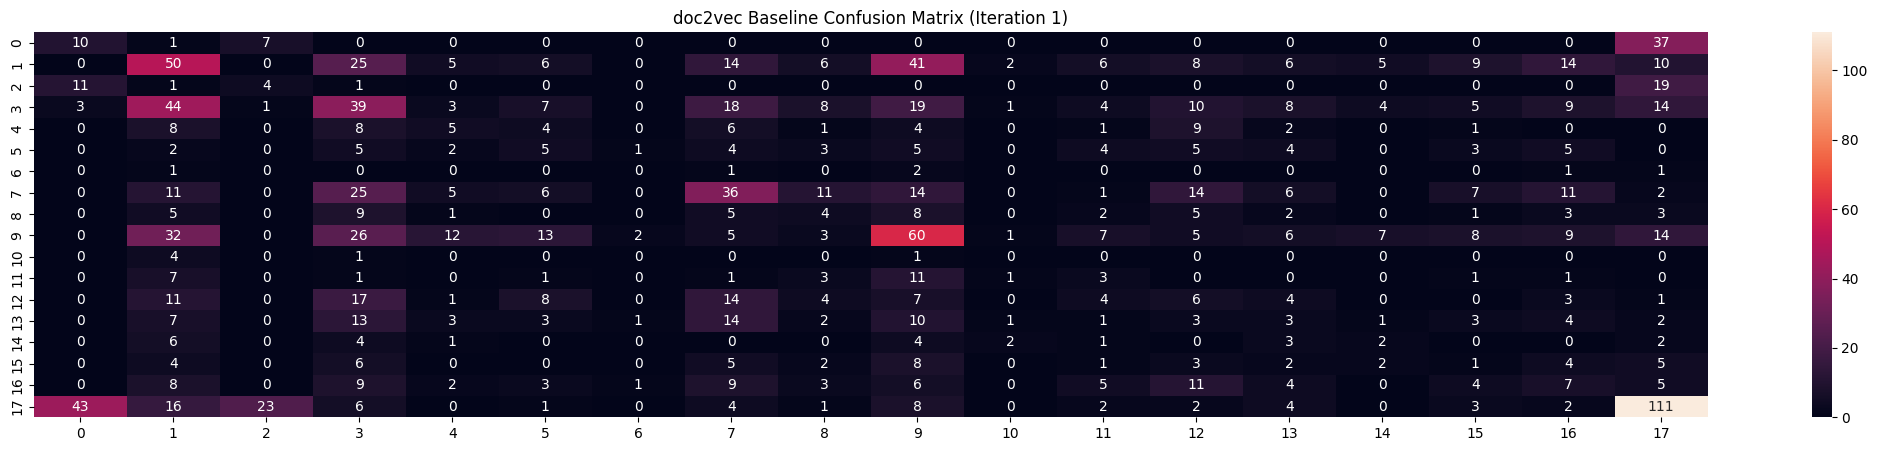

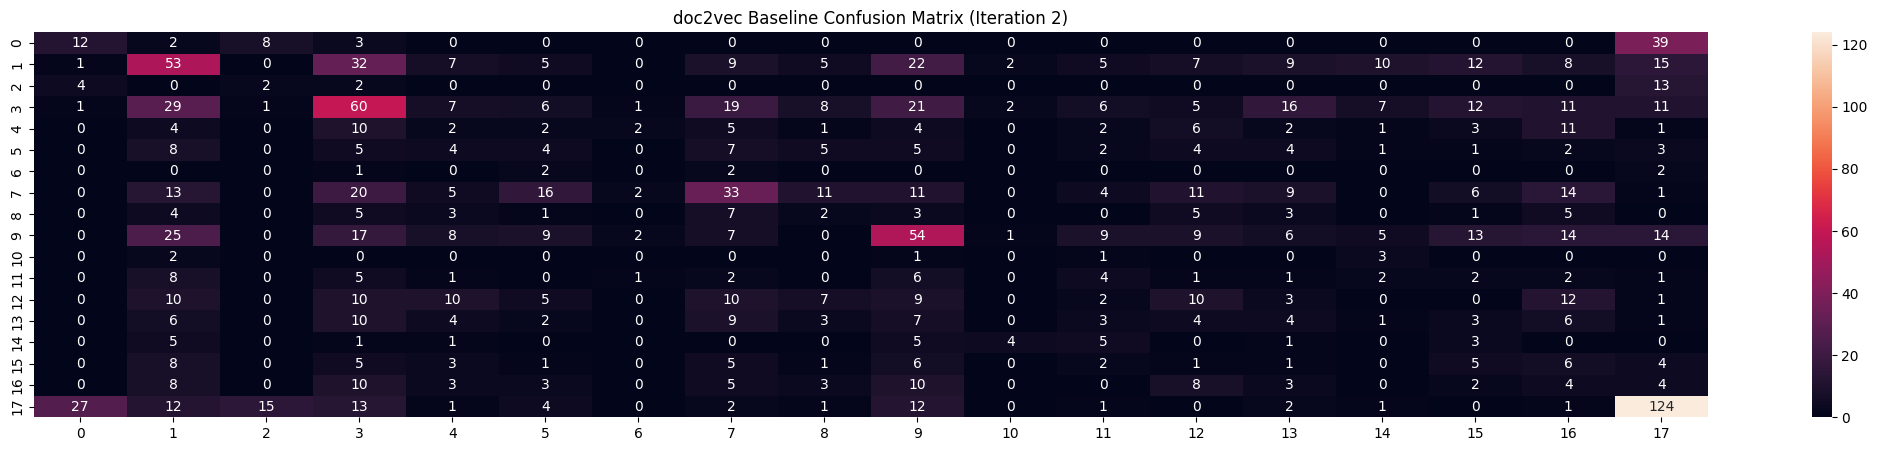

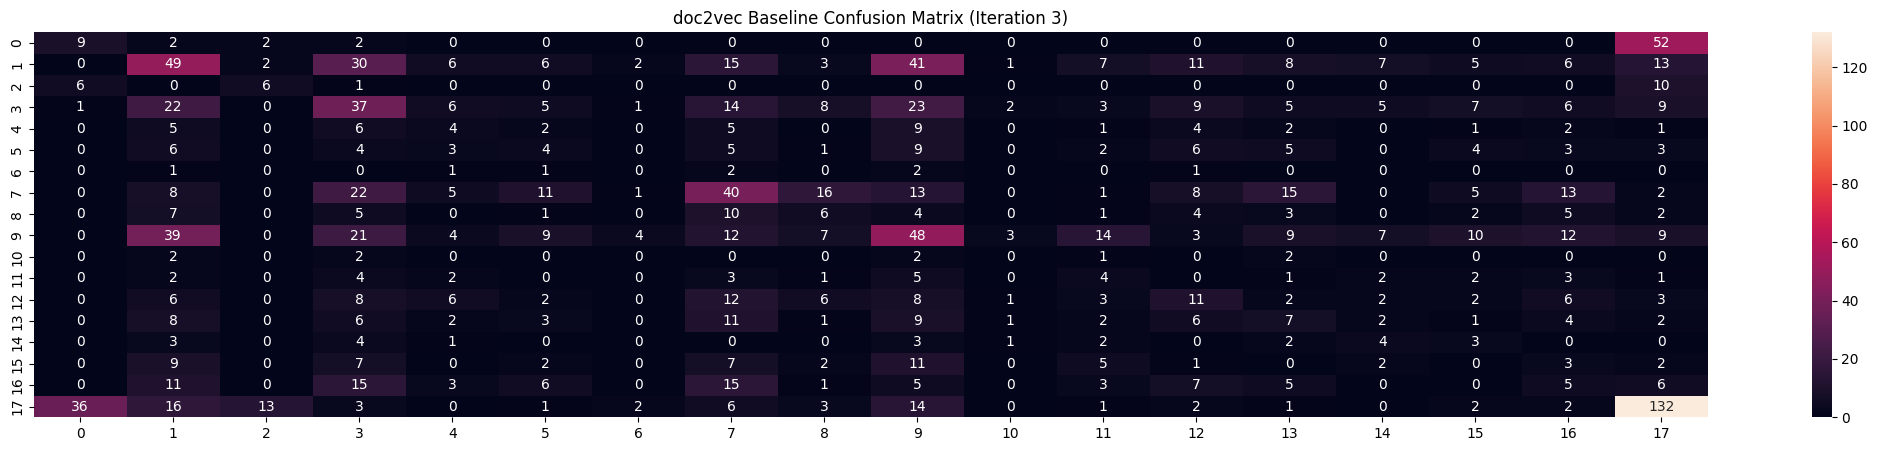

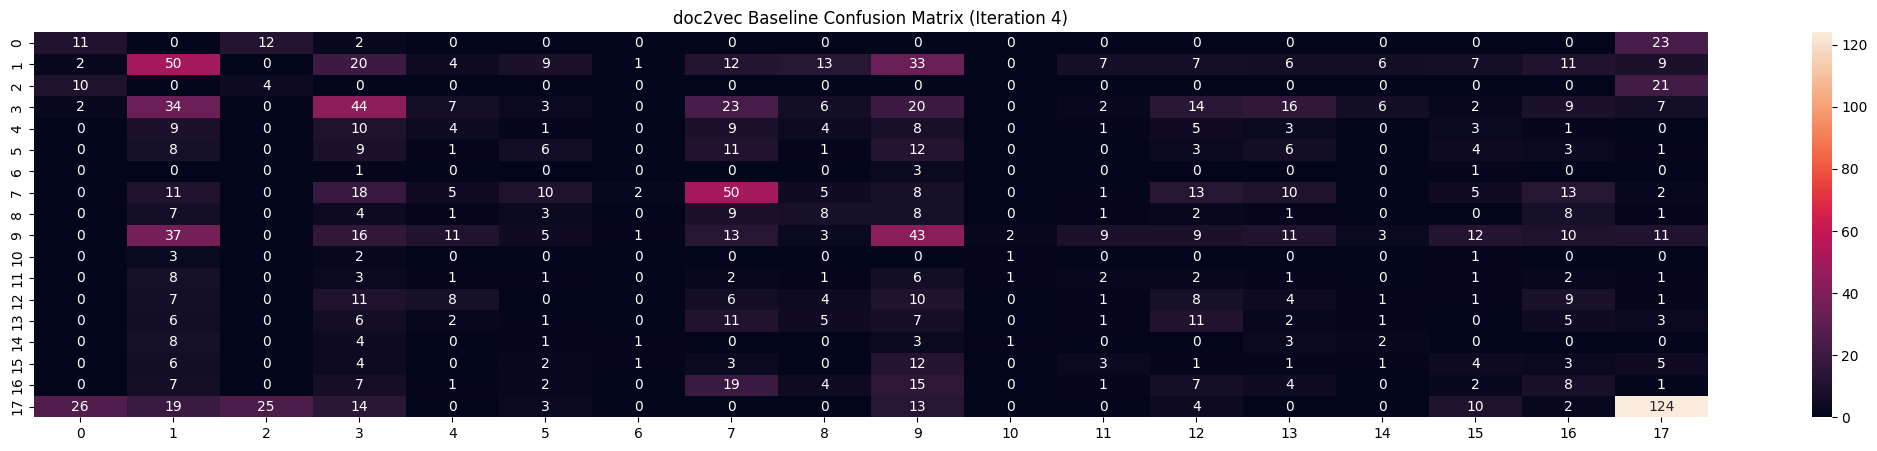

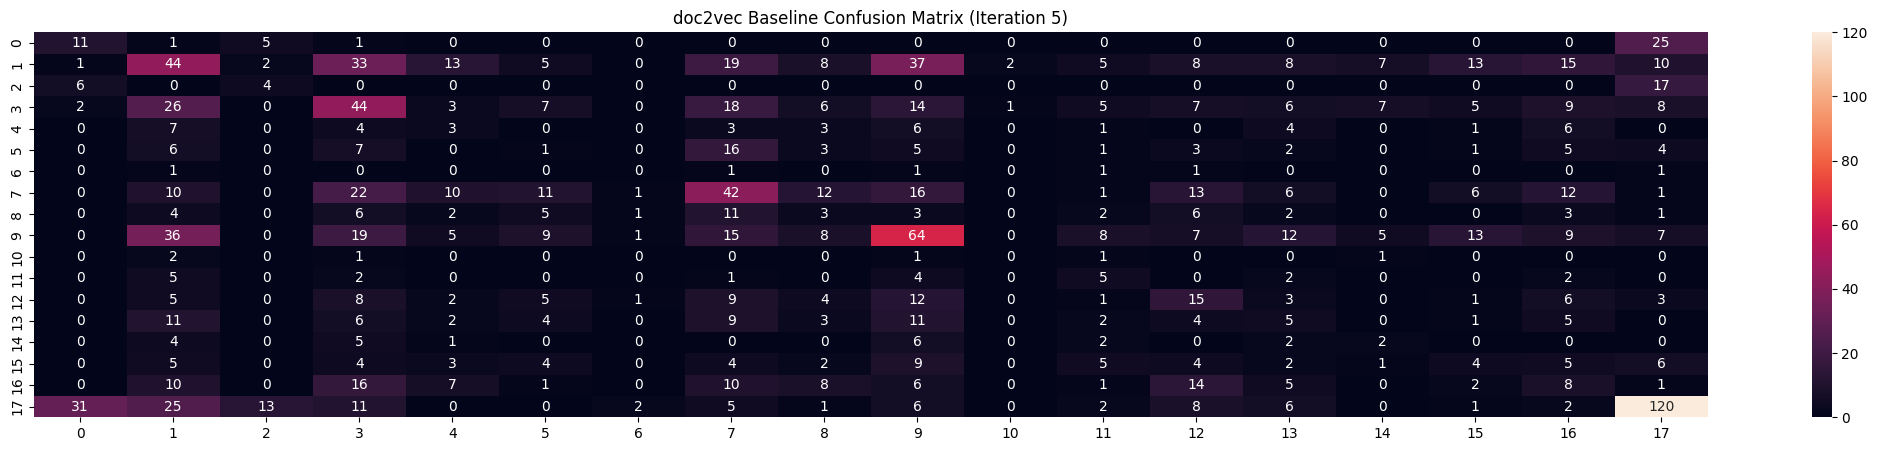

<Figure size 2700x500 with 0 Axes>

In [67]:
from sklearn import tree
from sklearn.metrics import confusion_matrix
import matplotlib.ticker as mticker

DE_baseline_scores = []
i = 0
while i < 5:
    X_train_base, X_test_base, Y_train_base, Y_test_base = train_test_split(dataPostDE, labelsDE, test_size=0.3) # 70% training and 30% test
    baseline = tree.DecisionTreeClassifier(random_state=0)
    baseline.fit(X_train_base, Y_train_base)
    Y_pred_baseline = baseline.predict(X_test_base)
    print("El accuracy para la iteración %i es %f"%(i+1, baseline.score(X_test_base, Y_test_base)))
    DE_baseline_scores.append(baseline.score(X_test_base, Y_test_base))

    cm_baseline = confusion_matrix(Y_test_base, Y_pred_baseline)
    ax_baseline= plt.subplot()
    # labels, title and ticks
    ax_baseline.set_xlabel('Predicted labels');
    ax_baseline.set_ylabel('True labels'); 
    ax_baseline.set_title('doc2vec Baseline Confusion Matrix (Iteration ' + str(i+1) + ')');
    plt.figure()
    sns.heatmap(cm_baseline, annot=True, fmt='g', ax=ax_baseline);  #annot=True to annotate cells, ftm='g' to disable scientific notation
    i = i+1

In [68]:
from numpy import mean

print("La media del accuracy del Baseline doc2vec: %f"%(mean(DE_baseline_scores)))

La media del accuracy del Baseline doc2vec: 0.234293


<h3>Utilizando TF-IDF</h3>

El accuracy para la iteración 1 es 0.404990
El accuracy para la iteración 2 es 0.415227
El accuracy para la iteración 3 es 0.421625
El accuracy para la iteración 4 es 0.424824
El accuracy para la iteración 5 es 0.410109


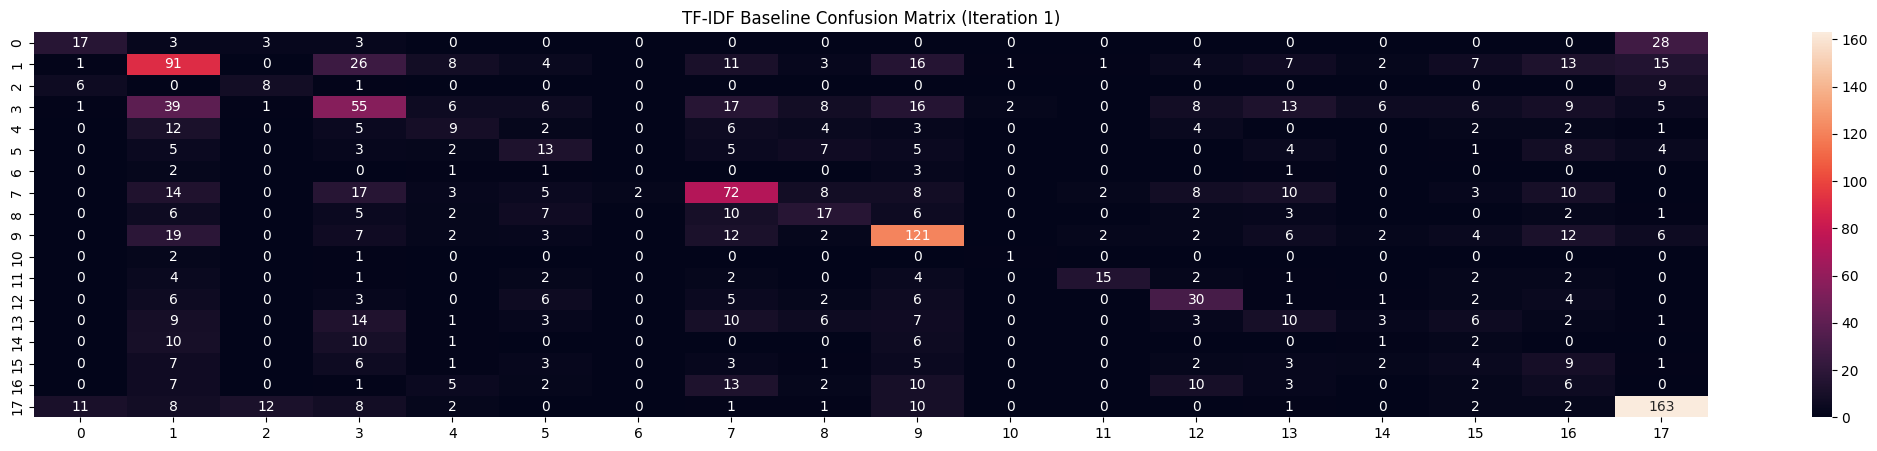

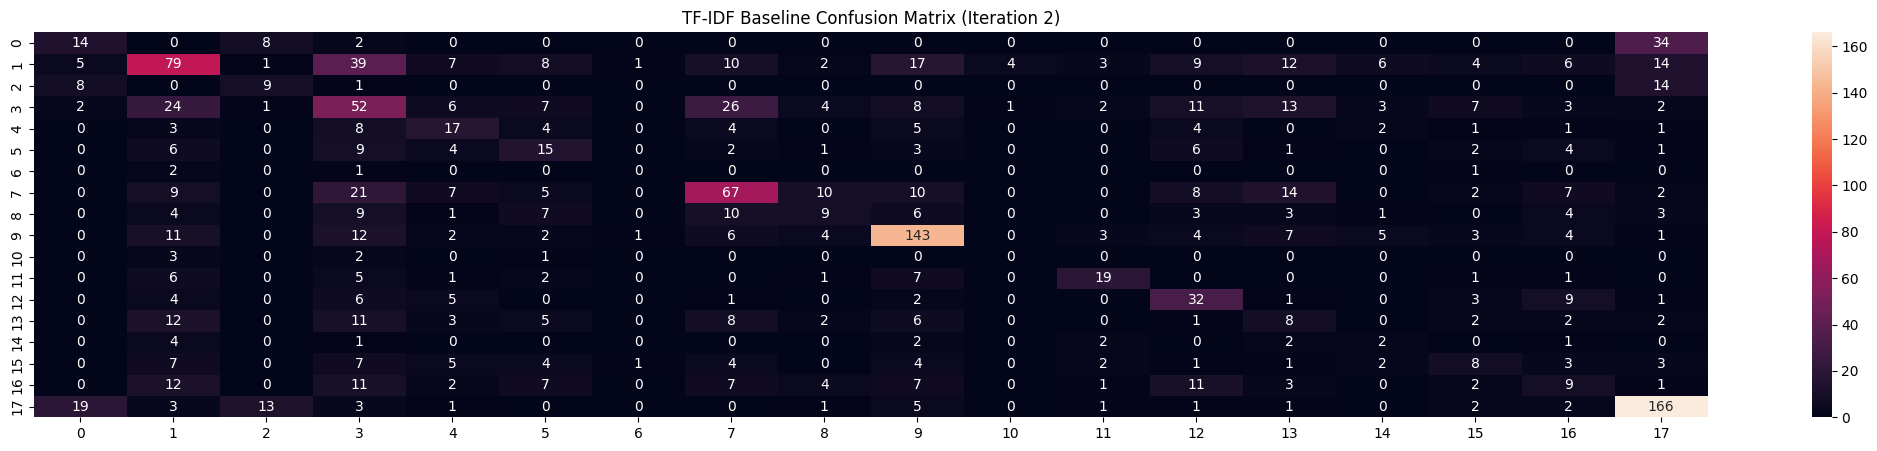

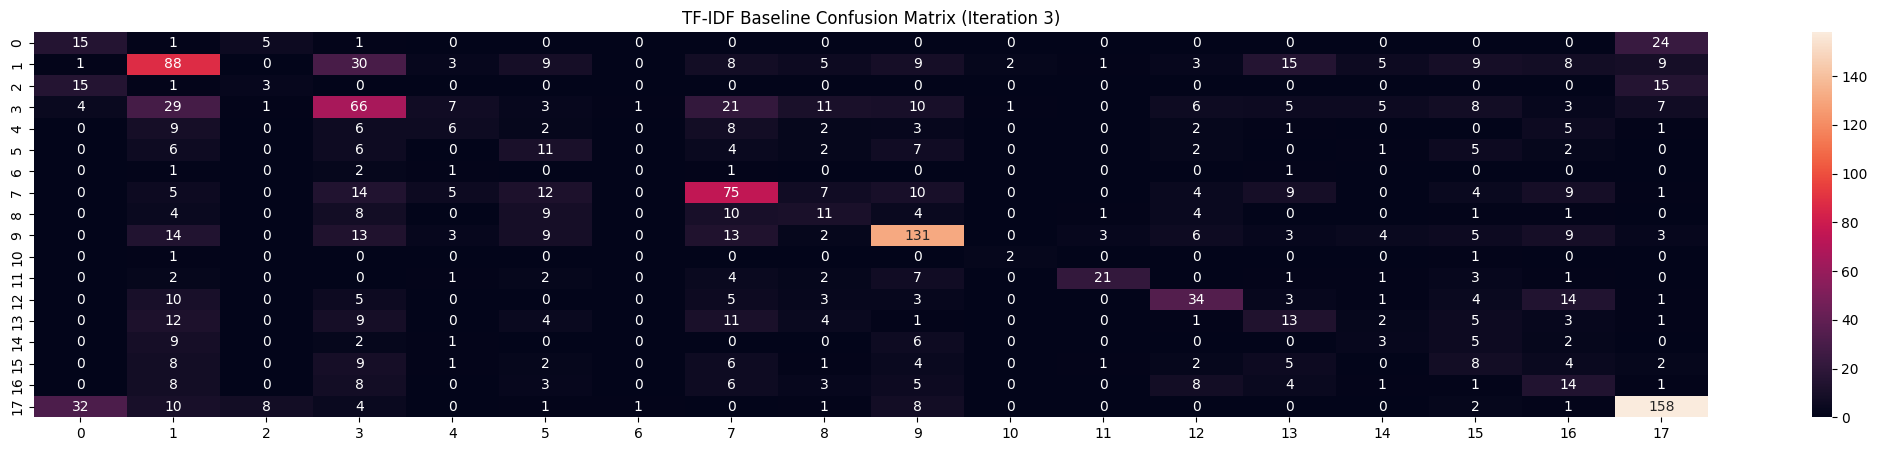

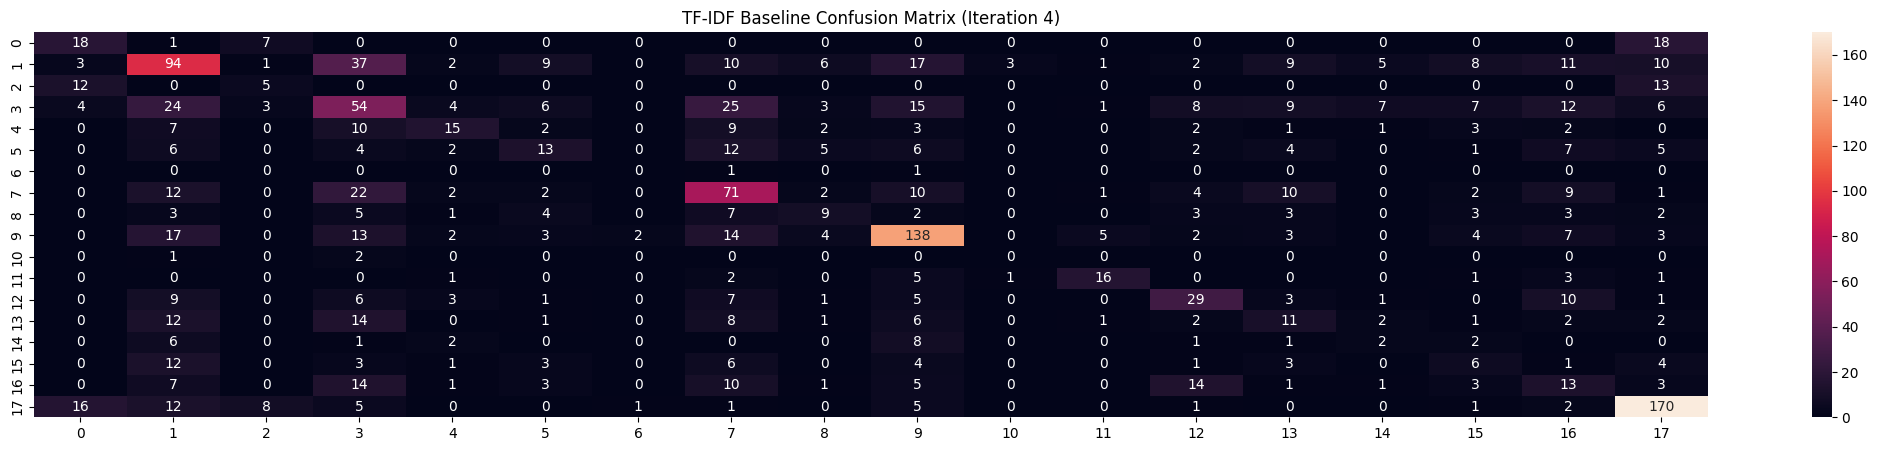

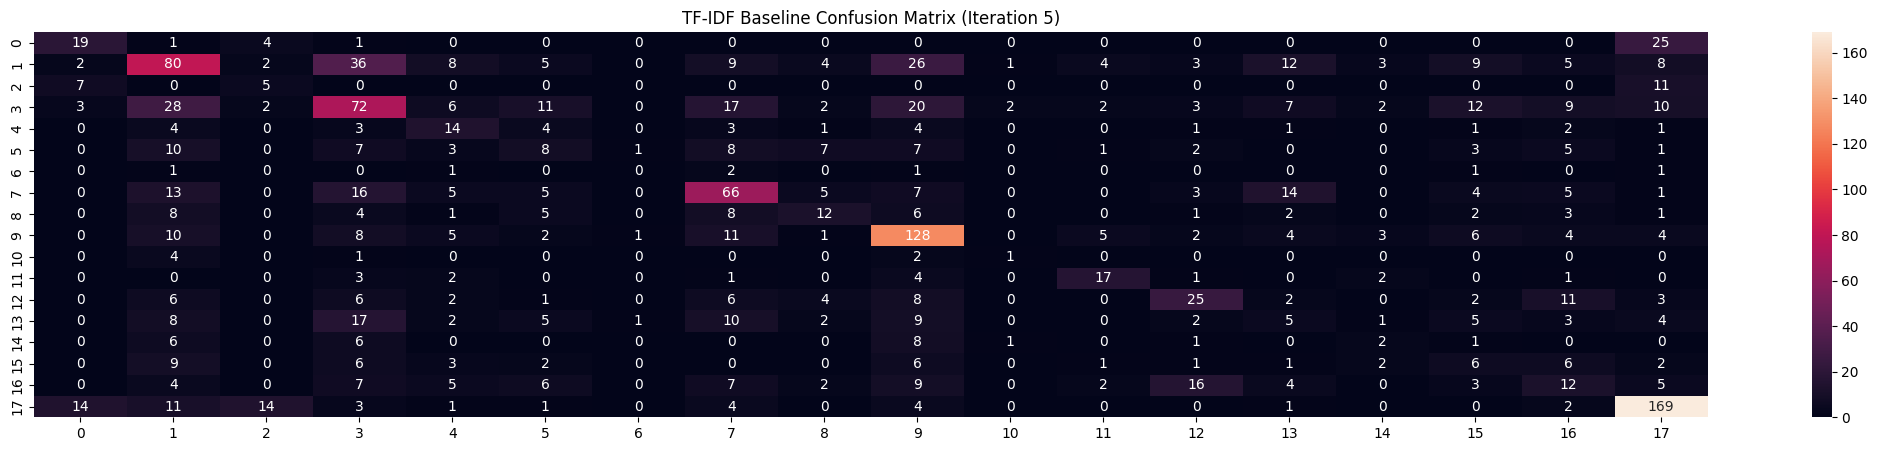

<Figure size 2700x500 with 0 Axes>

In [69]:
from sklearn import tree
from sklearn.metrics import confusion_matrix

TF_baseline_scores = []
i = 0
while i < 5:
    X_train_base, X_test_base, Y_train_base, Y_test_base = train_test_split(dataPostTF, labelsTF, test_size=0.3) # 70% training and 30% test
    baseline = tree.DecisionTreeClassifier(random_state=0)
    baseline.fit(X_train_base, Y_train_base)
    Y_pred_baseline = baseline.predict(X_test_base)
    print("El accuracy para la iteración %i es %f"%(i+1, baseline.score(X_test_base, Y_test_base)))
    TF_baseline_scores.append(baseline.score(X_test_base, Y_test_base))

    cm_baseline = confusion_matrix(Y_test_base, Y_pred_baseline)
    ax_baseline= plt.subplot()
    # labels, title and ticks
    ax_baseline.set_xlabel('Predicted labels');
    ax_baseline.set_ylabel('True labels'); 
    ax_baseline.set_title('TF-IDF Baseline Confusion Matrix (Iteration ' + str(i+1) + ')'); 
    plt.figure()
    sns.heatmap(cm_baseline, annot=True, fmt='g', ax=ax_baseline);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    i = i+1

In [70]:
from numpy import mean

print("La media del accuracy del Baseline TF-IDF: %f"%(mean(TF_baseline_scores)))

La media del accuracy del Baseline TF-IDF: 0.415355


<h3>Baseline: doc2vec vs TF-IDF</h3>

Ahora compararemos las medias del accuracy utilizando ambas vectorizaciones.

In [71]:
if mean(TF_baseline_scores) > mean(DE_baseline_scores):
    print("TF-IDF ha logrado mejor accuracy en el Baseline con una diferencia de %f" %(mean(TF_baseline_scores)-mean(DE_baseline_scores)))
elif mean(TF_baseline_scores) < mean(DE_baseline_scores):
    print("doc2vec ha logrado mejor accuracy en el Baseline con una diferencia de %f" %(mean(DE_baseline_scores)-mean(TF_baseline_scores)))
else:
    print("doc2vec y TF-IDF han logrado el mismo accuracy en el Baseline")   

TF-IDF ha logrado mejor accuracy en el Baseline con una diferencia de 0.181062


Como he explicado antes, en cada ejecución el resultado cambia, pero parece obvio que se logran mejores resultados con la vectorización TF-IDF por lo menos en lo que a accuracy se refiere.

<hr>

<h2>MLP utilizando doc2vec</h2>

<h3>Prueba del clasificador MLP con los parámetros por defecto (doc2vec)</h3>

Para empezar utilizamos el clasificador con los parámetros con valores por defecto, así podremos ver cuanto mejora el clasificador con los parámetros que nosotros propongamos.

In [72]:
from sklearn.neural_network import MLPClassifier

DE_basic_mlp_scores = []
i = 0
while i < 5:
    X_train, X_test, Y_train, Y_test = train_test_split(dataPostDE, labelsDE, test_size=0.3) # 70% training and 30% test
    mlp = MLPClassifier()
    mlp.fit(X_train, Y_train)
    Y_pred_mlp = mlp.predict(X_test)
    print("El accuracy para la iteracion %i es %f"%(i+1, mlp.score(X_test, Y_test)))
    DE_basic_mlp_scores.append(mlp.score(X_test, Y_test))
    i = i + 1

/home/gortxut/anaconda3/envs/md3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



El accuracy para la iteracion 1 es 0.377479
El accuracy para la iteracion 2 es 0.380038


/home/gortxut/anaconda3/envs/md3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



El accuracy para la iteracion 3 es 0.368522
El accuracy para la iteracion 4 es 0.369802
El accuracy para la iteracion 5 es 0.386436


/home/gortxut/anaconda3/envs/md3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



Al ver la información mostrada por la pantalla al ejecutar el clasificador podemos ver que no se llega la convergencia antes de llegar al número máximo de iteraciones (por defecto es 200), asi que para al llegar a ese determinado número de iteraciones.

In [73]:
from numpy import mean

print("La media del accuracy del MLP básico utilizando doc2vec: %f"%(mean(DE_basic_mlp_scores)))

La media del accuracy del MLP básico utilizando doc2vec: 0.376456


<h3>Prueba de parámetros de MLP (doc2vec)</h3>

Utilizaremos Hold-Out 70-30 sin repetición para ahorrar tiempo. Notaremos que este clasificador tarda bastante más que el DecisionTree utilizado como Baseline, ya que es más complejo, y eso se verá reflejado en el accuracy.

Mientras se van probando los parámetros, podremos ver el accuracy que logra cada clasificador en data_output/acc_parametros_MLP_DE.txt.

Después de hacer la prueba de parámetros, guardaremos el modelo que mejor accuracy logre en model/best_MLP_DE.model.

In [74]:
import os
import pickle
from joblib import dump, load
import warnings
from sklearn.exceptions import ConvergenceWarning

# Para ignorar los ConvergenceWarnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

hls_list = [(300,), (150,150), (100,100,100)]
act_list = ["identity", "logistic", "tanh", "relu"]
lr_list = ["constant", "invscaling", "adaptive"]
lri_list = [0.0005, 0.001, 0.008, 0.012]

# Si existe el fichero borrarlo.
# Como abrimos el fichero en modo 'append' si no borramos un fichero ya existente
# se añadirán los resultados al final y no se borrarán los anteriores.
if os.path.exists("data_output/acc_parametros_MLP_DE.txt"):
  os.remove("data_output/acc_parametros_MLP_DE.txt") 

X_train, X_test, Y_train, Y_test = train_test_split(dataPostDE, labelsDE, test_size=0.3) # 70% training and 30% test
best_acc = 0

for hls in hls_list:
    for act in act_list:
        for lr in lr_list:
            for lri in lri_list:
                cls = MLPClassifier(hidden_layer_sizes=hls, activation=act, learning_rate=lr, learning_rate_init=lri, max_iter=500)
                cls.fit(X_train, Y_train)
                f = open("data_output/acc_parametros_MLP_DE.txt", "a")
                f.write("El accuracy para  hls=%s, act=%s, lr=%s, lri=%f es %f \n" %(hls, act, lr, lri, cls.score(X_test, Y_test)))
                f.close()
                if cls.score(X_test, Y_test) >= best_acc:
                    best_acc = cls.score(X_test, Y_test)
                    best_cls = cls

dump(best_cls, "model/best_MLP_DE.model")

['model/best_MLP_DE.model']

In [75]:
from joblib import dump, load

best_cls = load("model/best_MLP_DE.model")
print("Los parámetros hls=%s, act=%s, lr=%s, lri=%f son los que mejor accuracy logran para doc2vec: %f" 
 %(best_cls.hidden_layer_sizes, best_cls.activation, best_cls.learning_rate, best_cls.learning_rate_init, best_cls.score(X_test, Y_test)))

Los parámetros hls=(150, 150), act=logistic, lr=adaptive, lri=0.001000 son los que mejor accuracy logran para doc2vec: 0.396673


<h3>Clasificación final mediante MLP (doc2vec)</h3>

Utilizaremos Hold-Out 70-30 repetido (5 iteraciones) y el mejor clasificador según nuestra prueba de parametros, cuyo modelo cargamos desde model/best_MLP_DE.model. El modelo ya está entrenado, por lo que la clasificación debería ser rápida.

El accuracy para la iteracion 1 es 0.404351
El accuracy para la iteracion 2 es 0.408189
El accuracy para la iteracion 3 es 0.397953
El accuracy para la iteracion 4 es 0.419706
El accuracy para la iteracion 5 es 0.396673


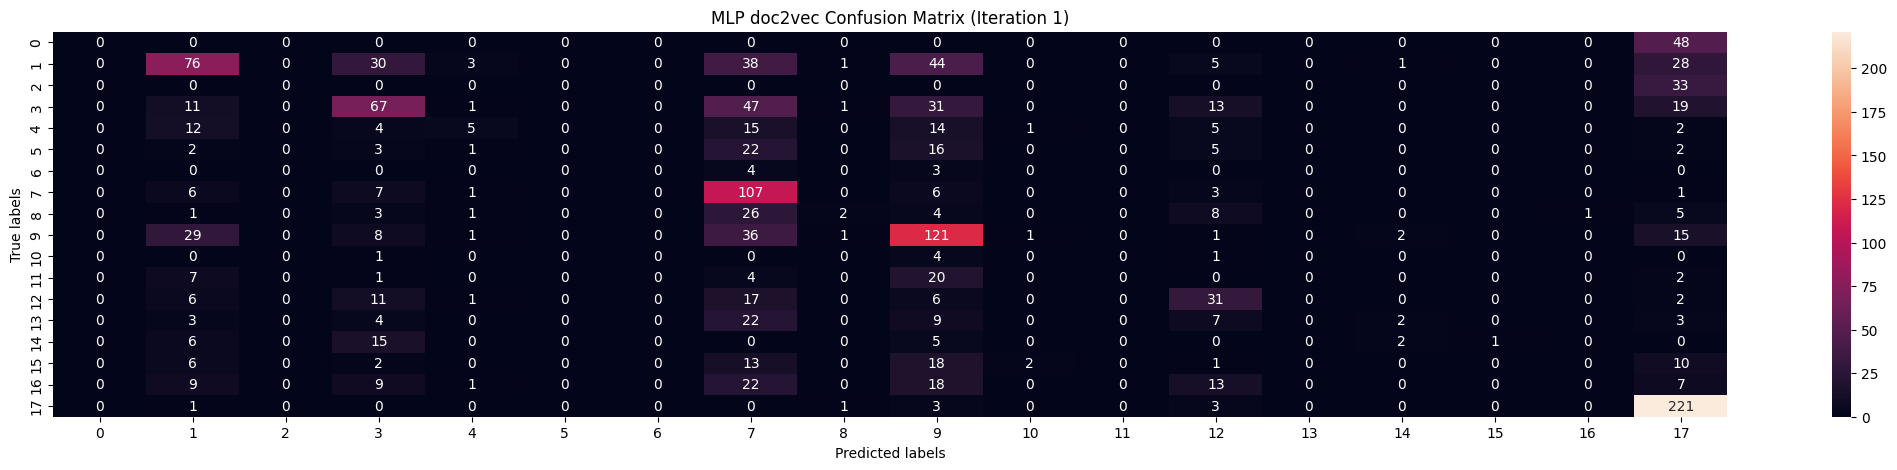

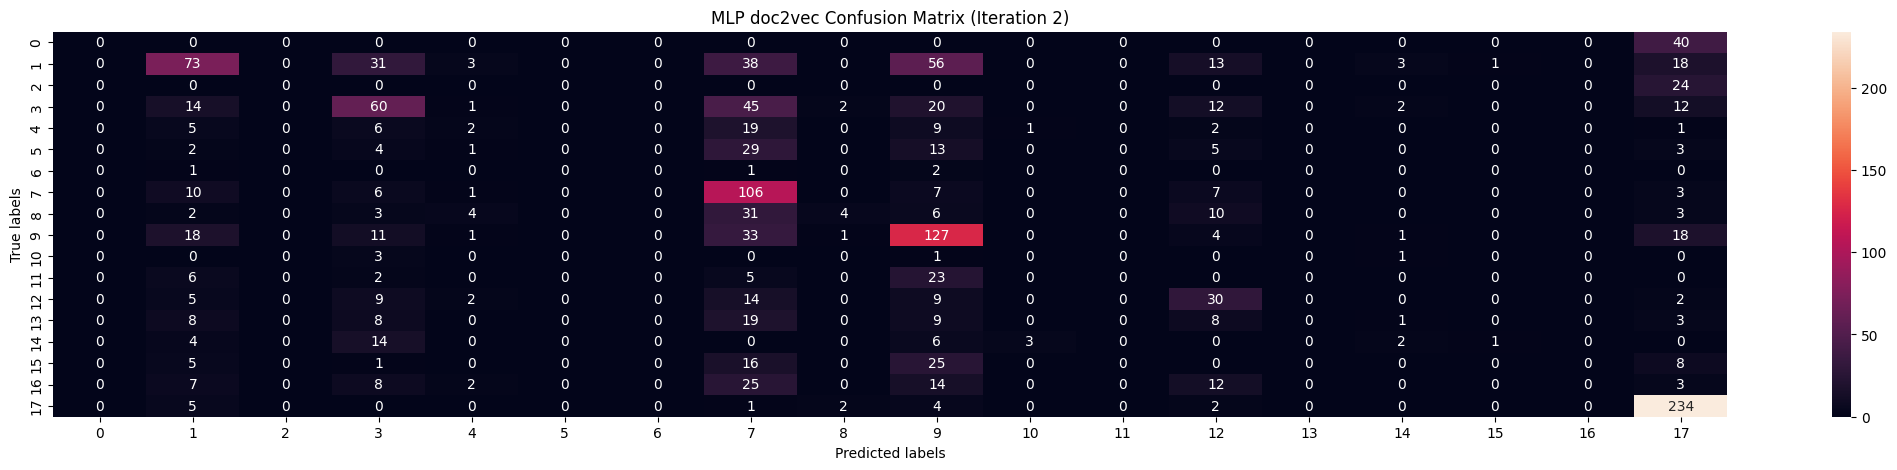

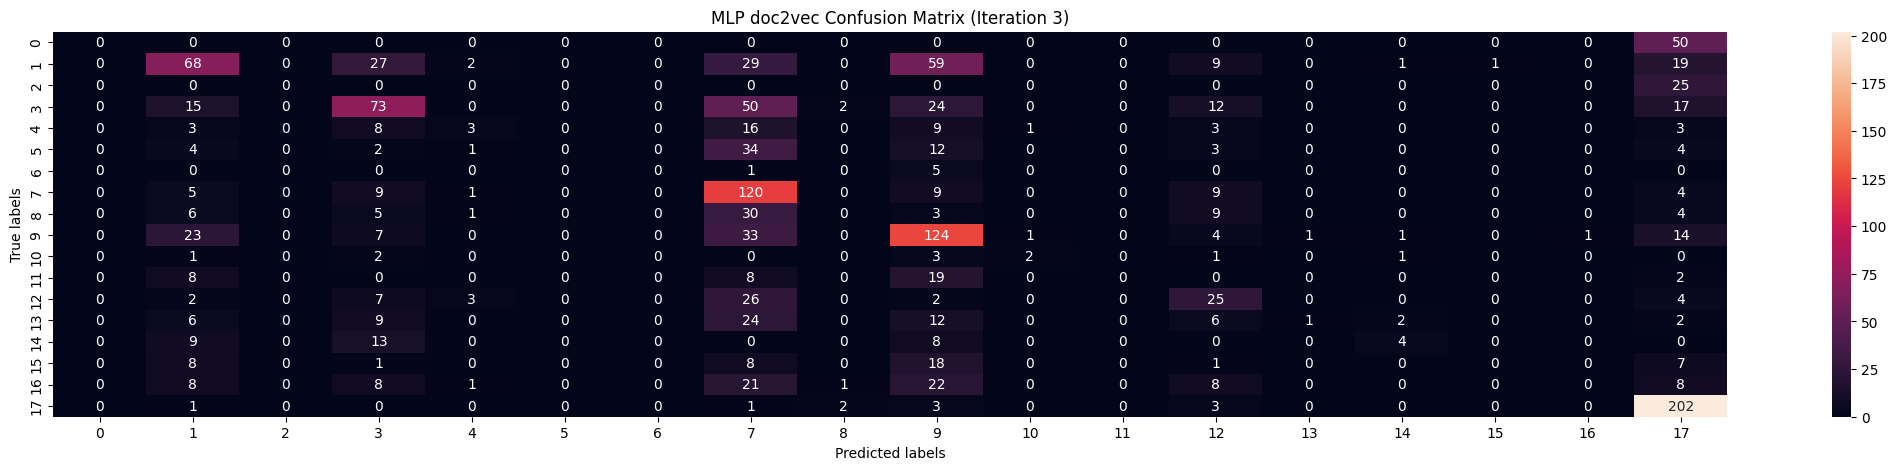

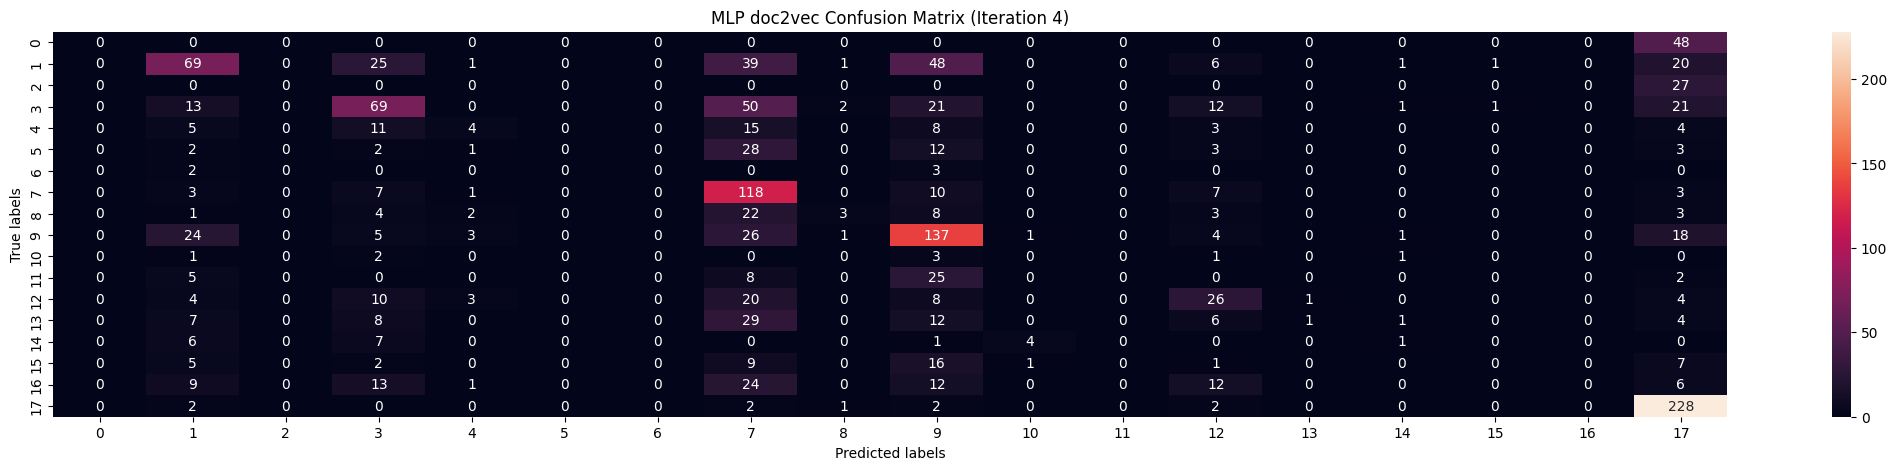

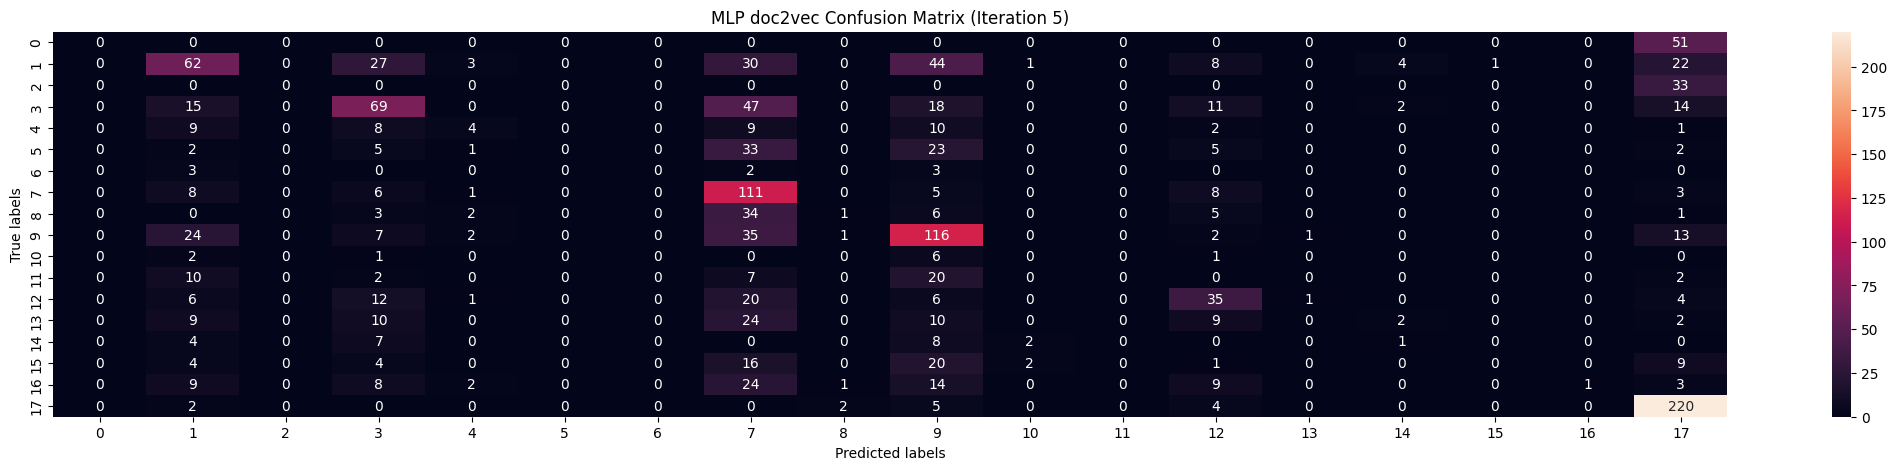

<Figure size 2700x500 with 0 Axes>

In [76]:
from sklearn.preprocessing import LabelBinarizer
import os
import numpy as np
from sklearn import metrics
from joblib import dump, load

DE_final_mlp_scores = []
fpr_list = {label: [] for label in np.unique(labelsDE)}
tpr_list = {label: [] for label in np.unique(labelsDE)}
roc_auc_list = {label: [] for label in np.unique(labelsDE)}
i = 0
while i < 5:
    X_train, X_test, Y_train, Y_test = train_test_split(dataPostDE, labelsDE, test_size=0.3) # 70% training and 30% test
    best_cls = load("model/best_MLP_DE.model")
    Y_pred_mlp = best_cls.predict(X_test)
    print("El accuracy para la iteracion %i es %f"%(i+1, best_cls.score(X_test, Y_test)))
    DE_final_mlp_scores.append(best_cls.score(X_test, Y_test))

    # MATRIZ DE CONFUSIÓN
    cm = confusion_matrix(Y_test, Y_pred_mlp)
    ax= plt.subplot()
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title('MLP doc2vec Confusion Matrix (Iteration ' + str(i+1) + ')'); 


    # PREPARAR LAS VARIABLES PARA LOS GRÁFICOS ROC
    label_binarizer = LabelBinarizer().fit(Y_train)
    y_onehot_test = label_binarizer.transform(Y_test)
    y_score = cls.predict_proba(X_test)
    for label in np.unique(labelsDE):
        class_of_interest = label
        class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

        fpr, tpr, _ = metrics.roc_curve(y_onehot_test[:, class_id], y_score[:, class_id])
        fpr_list[label].append(fpr)
        tpr_list[label].append(tpr)
        roc_auc = metrics.auc(fpr, tpr)
        roc_auc_list[label].append(roc_auc)

    if os.path.exists("data_output/MLP_DE_pred.txt"):
        os.remove("data_output/MLP_DE_pred.txt") 

    for y_pred, y_test in zip(Y_pred_mlp, Y_test):
        f = open("data_output/MLP_DE_pred.txt", "a")
        f.write("Predicción: %s | Real: %s \n" %(y_pred, y_test))
        f.close()

    i = i + 1

Después de guardar los TPR y FPR de cada clase respecto a las otras clases, ahora procedemos a crear las gráficas y las guardamos en data_graphics/ROC_doc2vec/

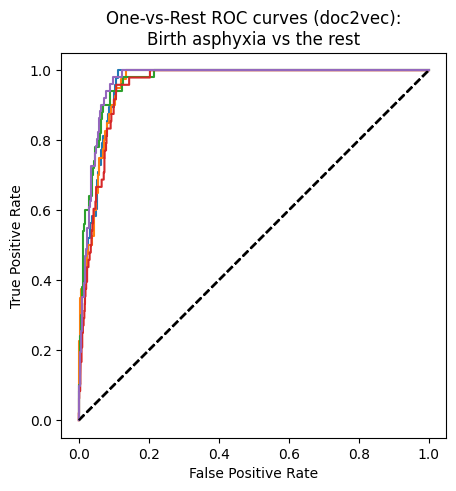

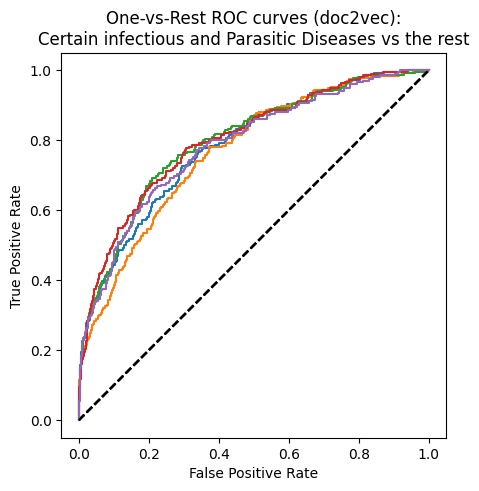

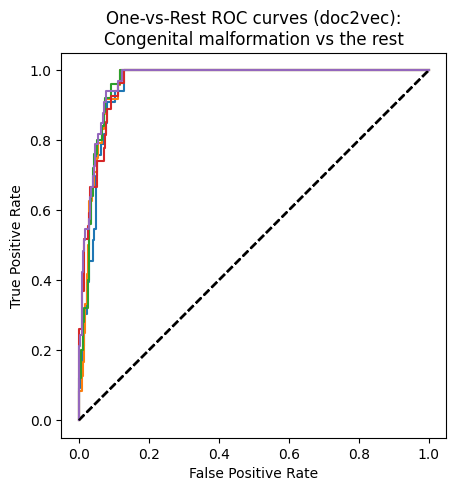

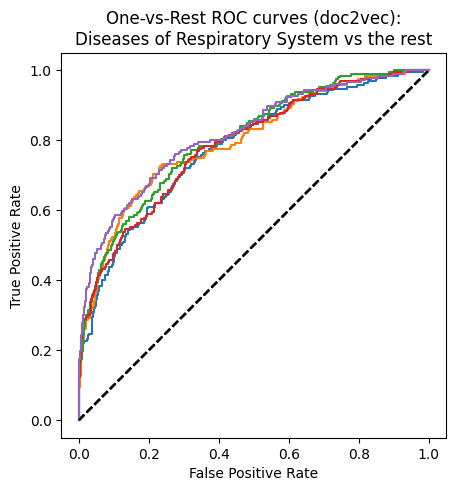

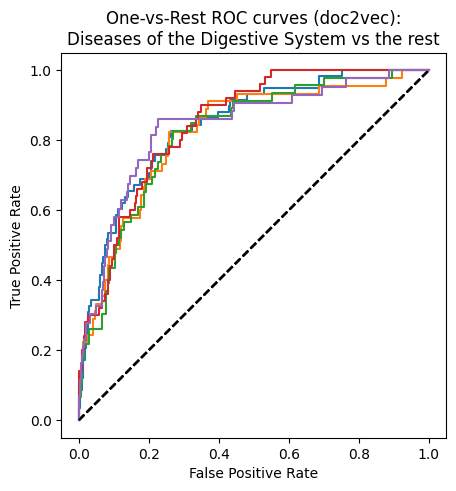

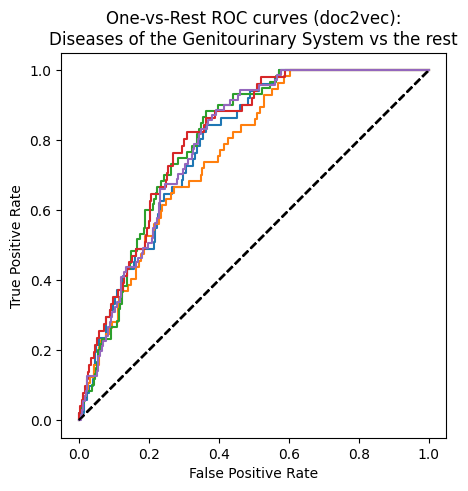

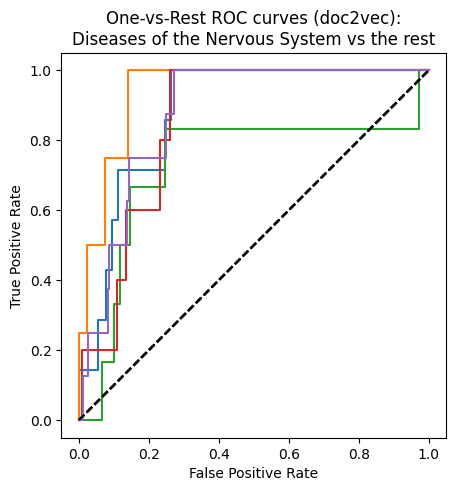

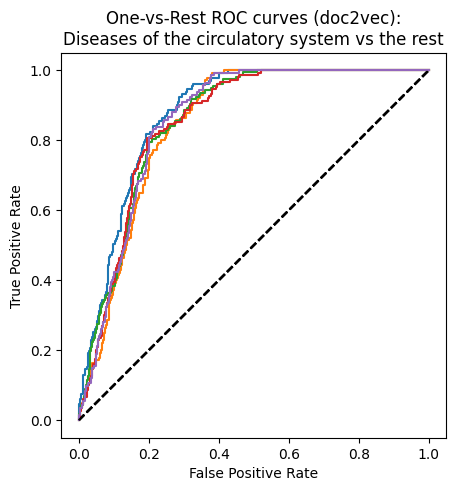

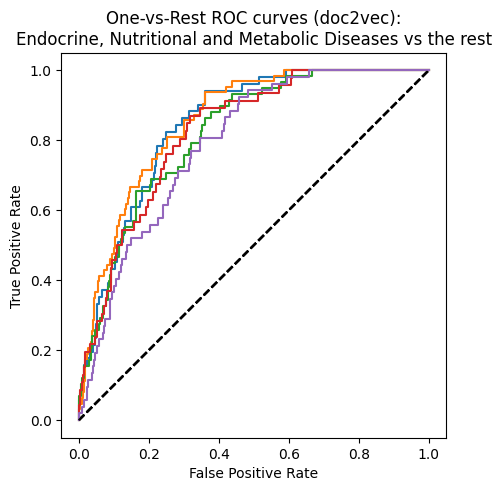

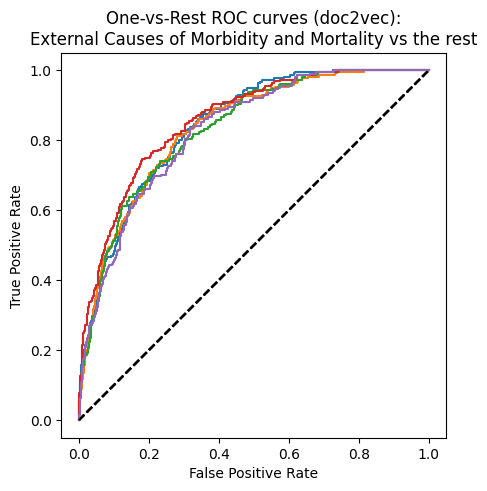

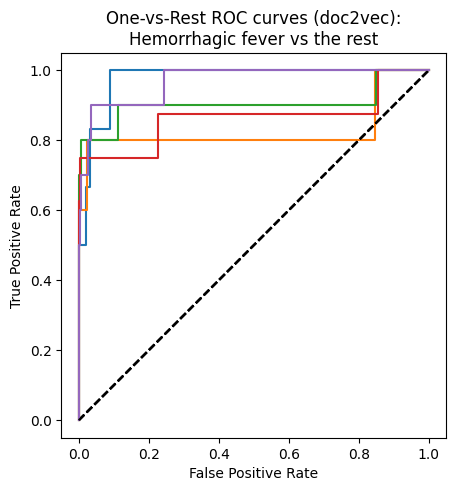

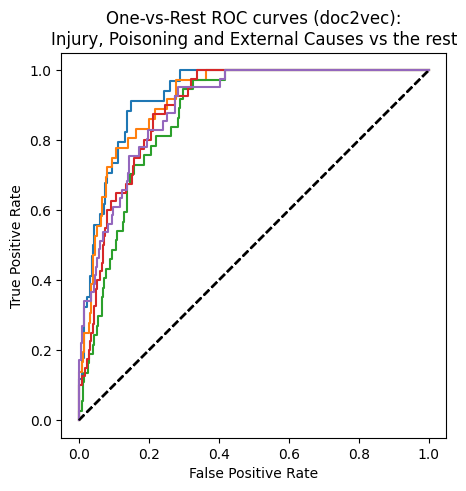

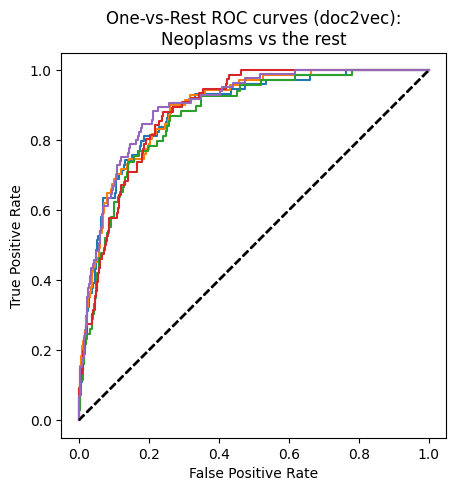

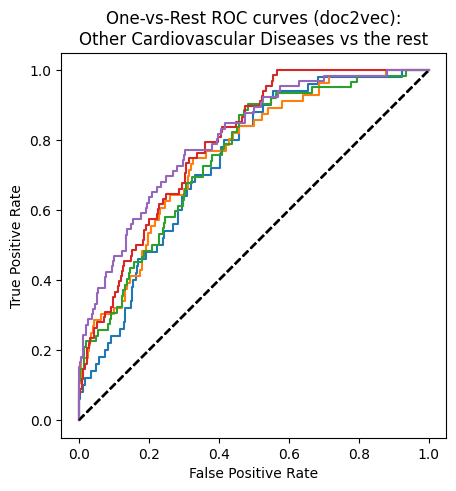

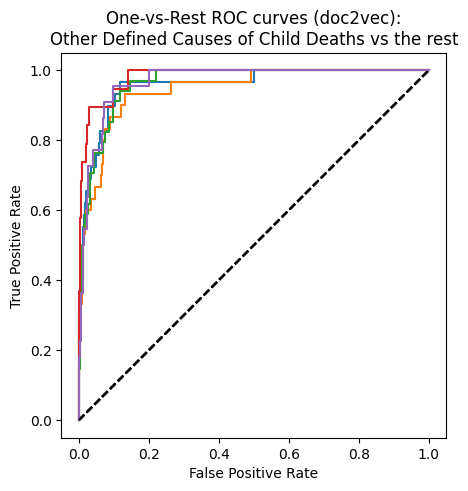

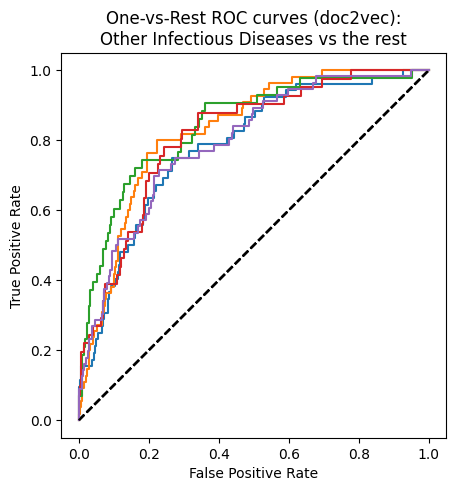

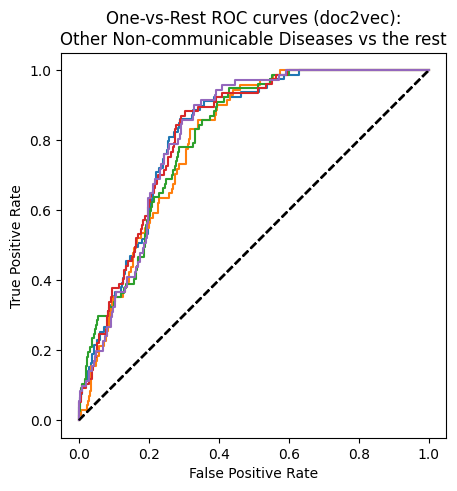

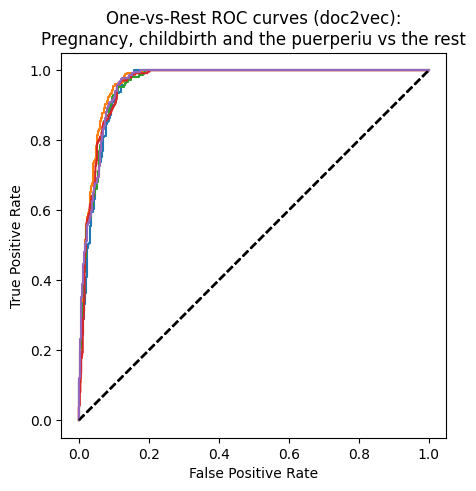

In [77]:
i = 0
for label in np.unique(labelsDE):
    plt.figure(i)
    i = i + 1
    for fpr, tpr, roc_auc in zip(fpr_list[label], tpr_list[label], roc_auc_list[label]):
        plt.plot(fpr,tpr,label="MLP doc2vec, AUC="+str(roc_auc))
        plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
        plt.axis("square")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("One-vs-Rest ROC curves (doc2vec):\n" + label + " vs the rest")
        plt.savefig("data_graphics/ROC_doc2vec/" + label + ".png")

In [78]:
from numpy import mean

print("La media del accuracy del MLP final utilizando doc2vec: %f"%(mean(DE_final_mlp_scores)))

La media del accuracy del MLP final utilizando doc2vec: 0.405374


<hr>

<h2>MLP utilizando TF-IDF</h2>

Ahora haremos exactamente lo mismo que con doc2vec pero esta vez utilizando el dataset post TF-IDF.

<h3>Prueba del clasificador MLP con los parámetros por defecto (TF-IDF)</h3>

In [79]:
from sklearn.neural_network import MLPClassifier

TF_basic_mlp_scores = []
i = 0
while i < 5:
    X_train, X_test, Y_train, Y_test = train_test_split(dataPostTF, labelsTF, test_size=0.3) # 70% training and 30% test
    mlp = MLPClassifier()
    mlp.fit(X_train, Y_train)
    Y_pred_mlp = mlp.predict(X_test)
    print("El accuracy para la iteracion %i es %f"%(i+1, mlp.score(X_test, Y_test)))
    TF_basic_mlp_scores.append(mlp.score(X_test, Y_test))
    i = i + 1

El accuracy para la iteracion 1 es 0.506078
El accuracy para la iteracion 2 es 0.535509
El accuracy para la iteracion 3 es 0.528471
El accuracy para la iteracion 4 es 0.506718
El accuracy para la iteracion 5 es 0.509917


Al ver la información mostrada por la pantalla al ejecutar el clasificador podemos ver que no se llega la convergencia antes de llegar al número máximo de iteraciones (por defecto es 200), asi que para al llegar a ese determinado número de iteraciones

In [80]:
from numpy import mean

print("La media del accuracy del MLP básico utilizando TF-IDF: %f"%(mean(TF_basic_mlp_scores)))

La media del accuracy del MLP básico utilizando TF-IDF: 0.517338


<h3>Prueba de parámetros de MLP (TF-IDF)</h3>

Utilizaremos Hold-Out 70-30 para ahorrar tiempo. Notaremos que este clasificador tarda bastante más que KNN, ya que es más complejo, y eso se verá reflejado en el accuracy.

Podemos ver que después de juntar los parámetros que mejor resultado nos han dado por separado, al juntarlos nos da incluso peor resultado que el básico. Esto se debe a que los parámetros no son independientes y las combinaciones entre ellos influyen en el resultado. Además, no hemos hecho Hold-Out repetido, por lo que puede que el split que haya salido tenga una influencia negativa en el resultado.

In [81]:
import os
import pickle
from joblib import dump, load
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

hls_list = [(300,), (150,150), (100,100,100)]
act_list = ["identity", "logistic", "tanh", "relu"]
lr_list = ["constant", "invscaling", "adaptive"]
lri_list = [0.0005, 0.001, 0.008, 0.012]

# Si existe el fichero borrarlo.
# Como abrimos el fichero en modo 'append' si no borramos un fichero ya existente
# se añadirán los resultados al final y no se borrarán los anteriores.
if os.path.exists("data_output/acc_parametros_MLP_TF.txt"):
  os.remove("data_output/acc_parametros_MLP_TF.txt") 

X_train, X_test, Y_train, Y_test = train_test_split(dataPostTF, labelsTF, test_size=0.3) # 70% training and 30% test
best_acc = 0

for hls in hls_list:
    for act in act_list:
        for lr in lr_list:
            for lri in lri_list:
                cls = MLPClassifier(hidden_layer_sizes=hls, activation=act, learning_rate=lr, learning_rate_init=lri, max_iter=500)
                cls.fit(X_train, Y_train)
                f = open("data_output/acc_parametros_MLP_TF.txt", "a")
                f.write("El accuracy para  hls=%s, act=%s, lr=%s, lri=%f es %f \n" %(hls, act, lr, lri, cls.score(X_test, Y_test)))
                f.close()
                if cls.score(X_test, Y_test) >= best_acc:
                    best_acc = cls.score(X_test, Y_test)
                    best_cls = cls

dump(best_cls, "model/best_MLP_TF.model")

['model/best_MLP_TF.model']

In [82]:
from joblib import dump, load

best_cls = load("model/best_MLP_TF.model")
print("Los parámetros hls=%s, act=%s, lr=%s, lri=%f son los que mejor accuracy logran para TF-IDF: %f" 
 %(best_cls.hidden_layer_sizes, best_cls.activation, best_cls.learning_rate, best_cls.learning_rate_init, best_cls.score(X_test, Y_test)))

Los parámetros hls=(300,), act=relu, lr=invscaling, lri=0.000500 son los que mejor accuracy logran para TF-IDF: 0.525912


<h3>Clasificación final mediante MLP (TF-IDF)</h3>

El accuracy para la iteracion 1 es 0.858605
El accuracy para la iteracion 2 es 0.847729
El accuracy para la iteracion 3 es 0.862444
El accuracy para la iteracion 4 es 0.869482
El accuracy para la iteracion 5 es 0.856686


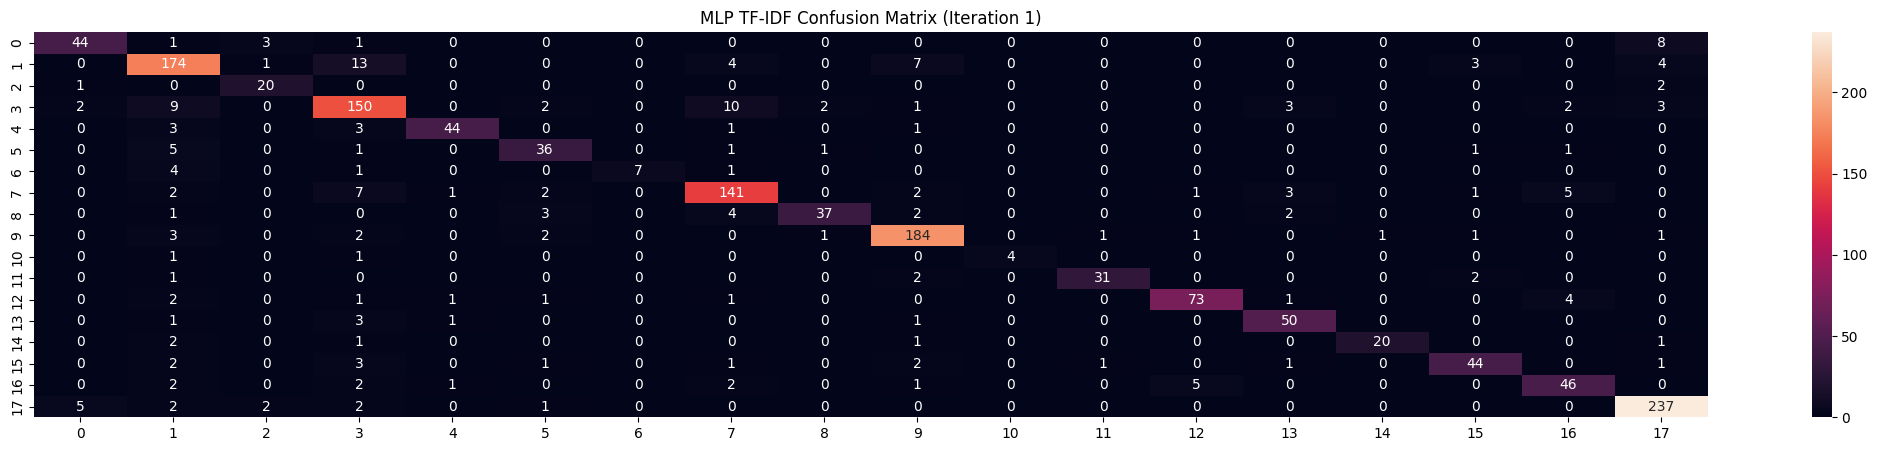

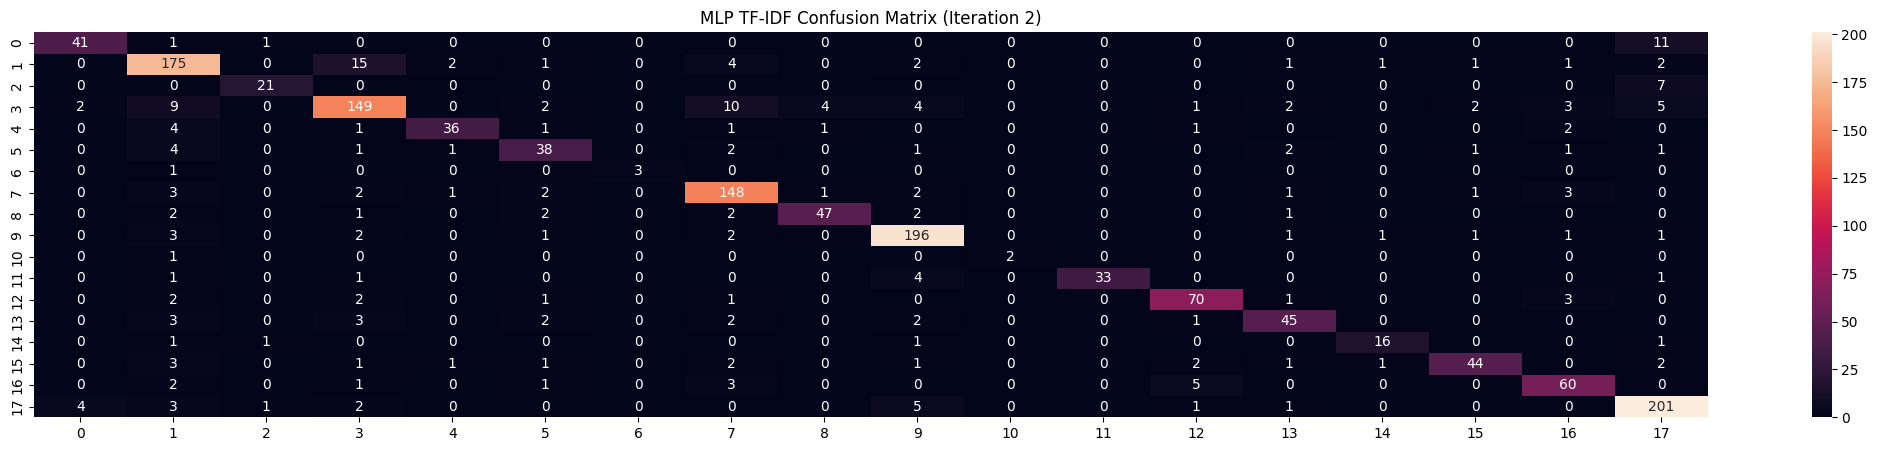

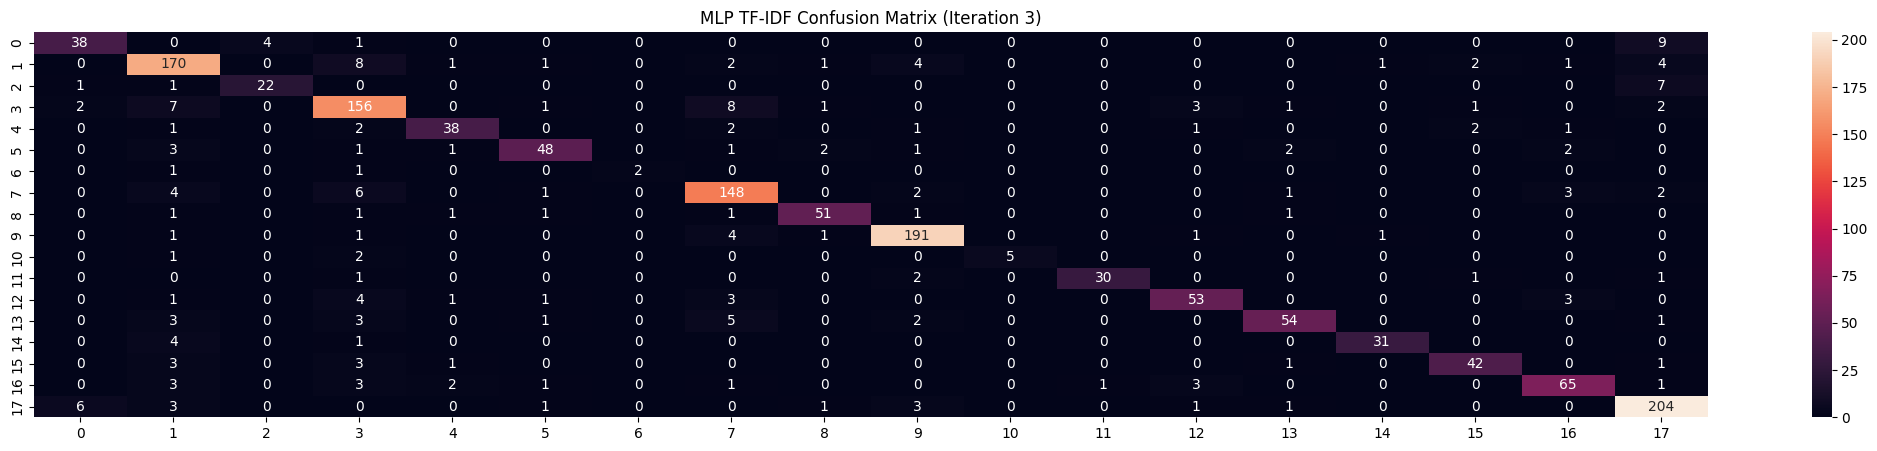

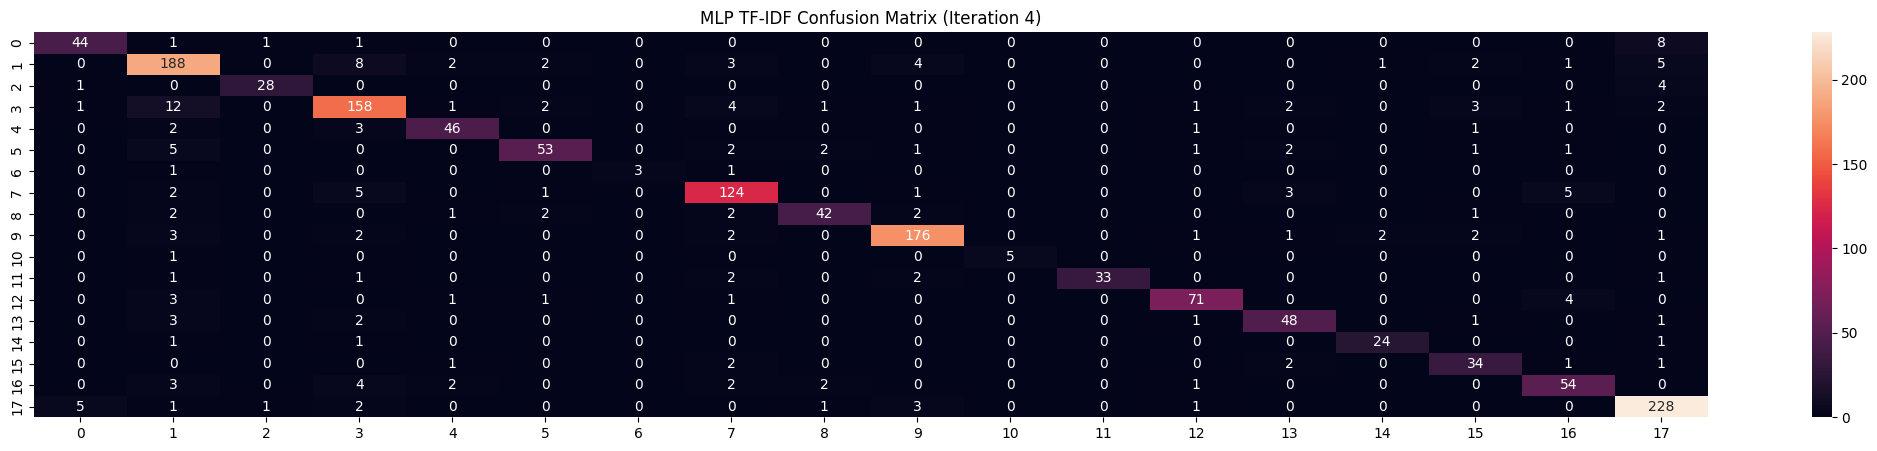

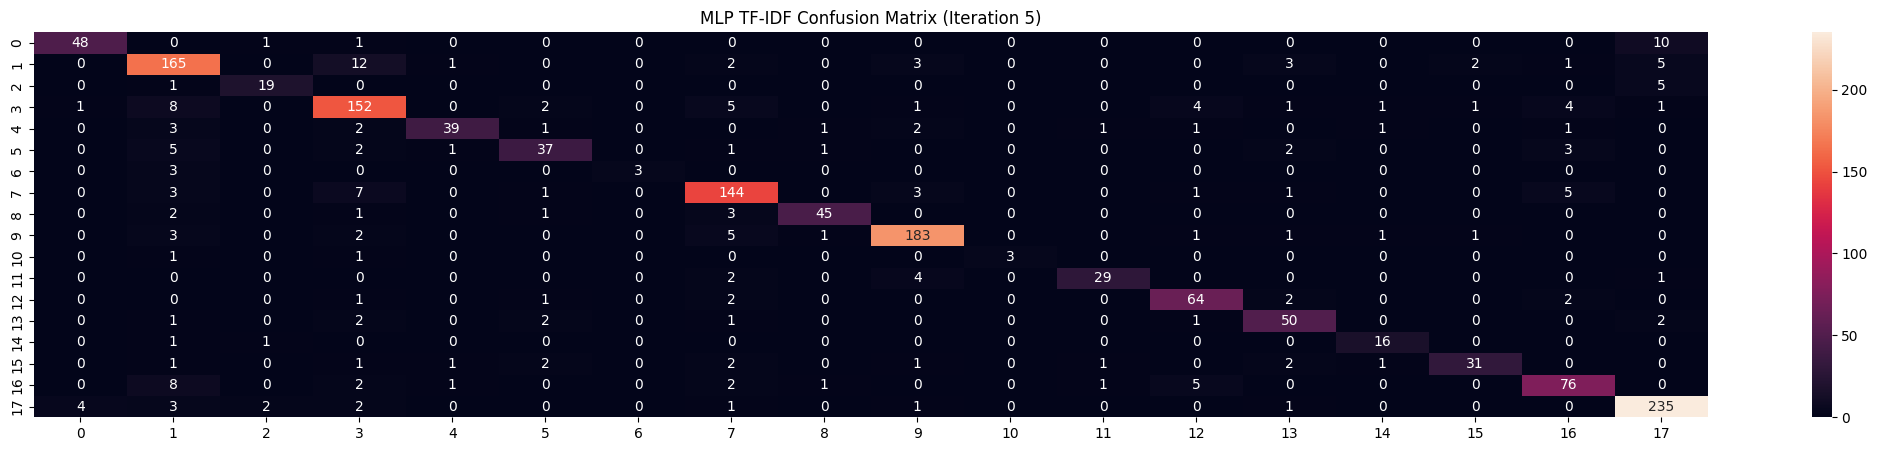

<Figure size 2700x500 with 0 Axes>

In [83]:
from sklearn.preprocessing import LabelBinarizer
import os
import numpy as np
from sklearn import metrics
from joblib import dump, load

TF_final_mlp_scores = []
fpr_list = {label: [] for label in np.unique(labelsTF)}
tpr_list = {label: [] for label in np.unique(labelsTF)}
roc_auc_list = {label: [] for label in np.unique(labelsTF)}
i = 0
while i < 5:
    X_train, X_test, Y_train, Y_test = train_test_split(dataPostTF, labelsTF, test_size=0.3) # 70% training and 30% test
    best_cls = load("model/best_MLP_TF.model")
    Y_pred_mlp = best_cls.predict(X_test)
    print("El accuracy para la iteracion %i es %f"%(i+1, best_cls.score(X_test, Y_test)))
    TF_final_mlp_scores.append(best_cls.score(X_test, Y_test))

    # MATRIZ DE CONFUSIÓN
    cm = confusion_matrix(Y_test, Y_pred_mlp)
    # labels, title and ticks
    ax= plt.subplot()
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title('MLP TF-IDF Confusion Matrix (Iteration ' + str(i+1) + ')'); 
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation


    # PREPARAMOS LAS VARIABLES PARA LOS GRÁFICOS ROC
    label_binarizer = LabelBinarizer().fit(Y_train)
    y_onehot_test = label_binarizer.transform(Y_test)
    y_score = cls.predict_proba(X_test)
    for label in np.unique(labelsTF):
        class_of_interest = label
        class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

        fpr, tpr, _ = metrics.roc_curve(y_onehot_test[:, class_id], y_score[:, class_id])
        fpr_list[label].append(fpr)
        tpr_list[label].append(tpr)
        roc_auc = metrics.auc(fpr, tpr)
        roc_auc_list[label].append(roc_auc)

    if os.path.exists("data_output/MLP_TF_pred.txt"):
        os.remove("data_output/MLP_TF_pred.txt") 

    for y_pred, y_test in zip(Y_pred_mlp, Y_test):
        f = open("data_output/MLP_TF_pred.txt", "a")
        f.write("Predicción: %s | Real: %s \n" %(y_pred, y_test))
        f.close()

    i = i + 1

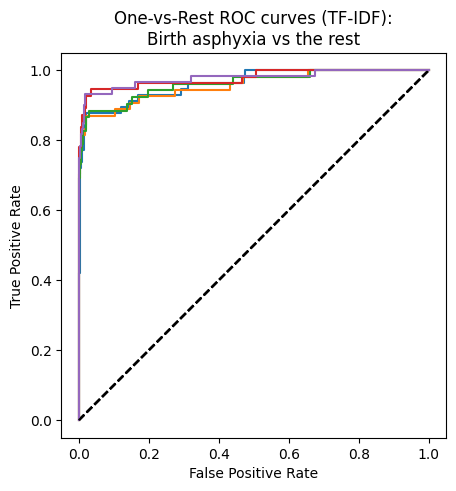

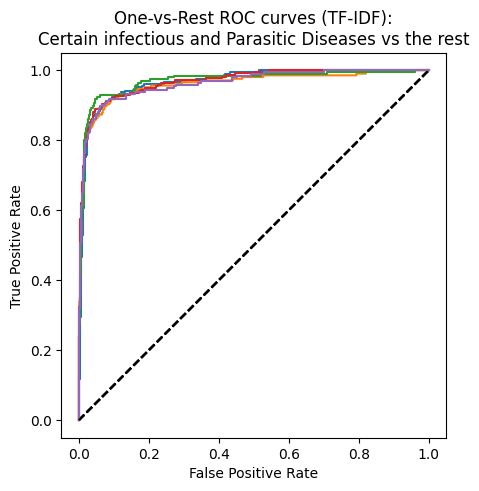

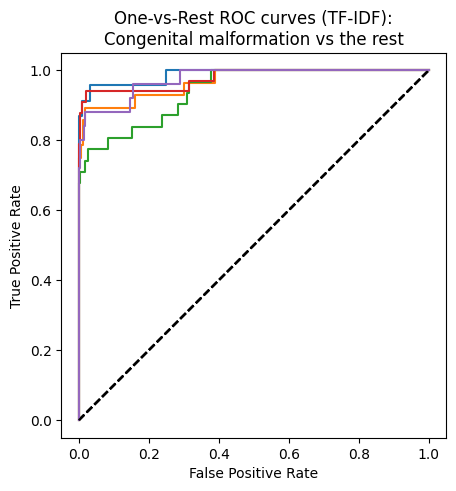

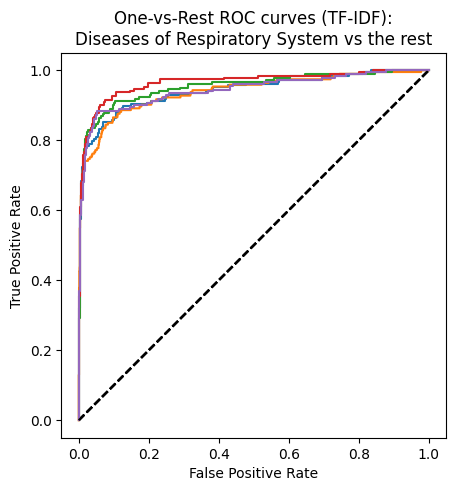

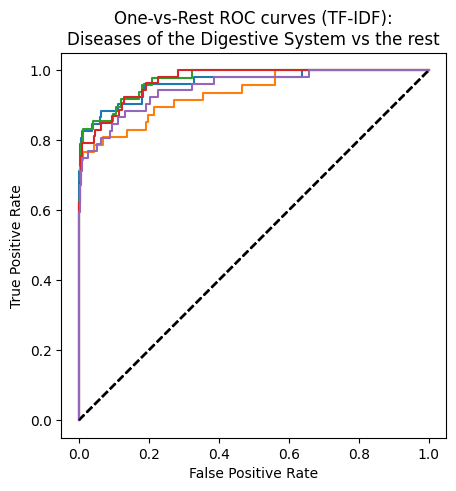

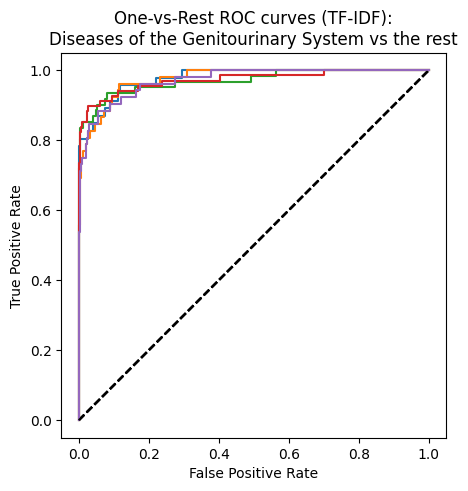

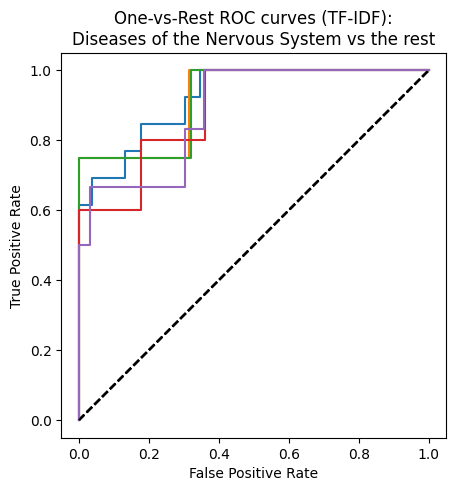

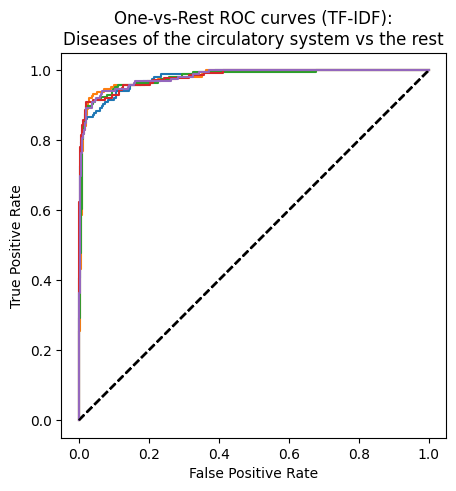

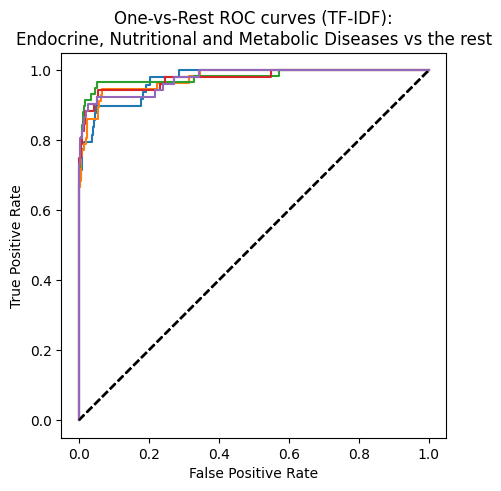

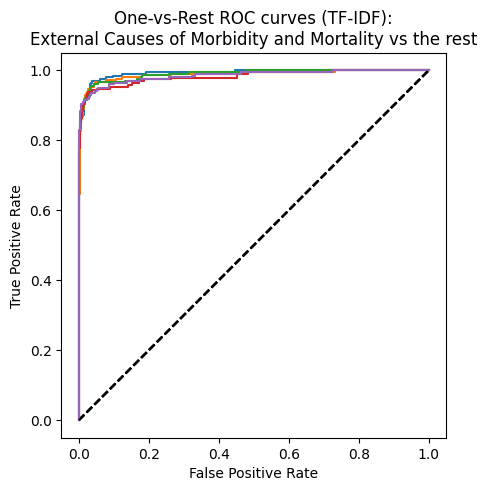

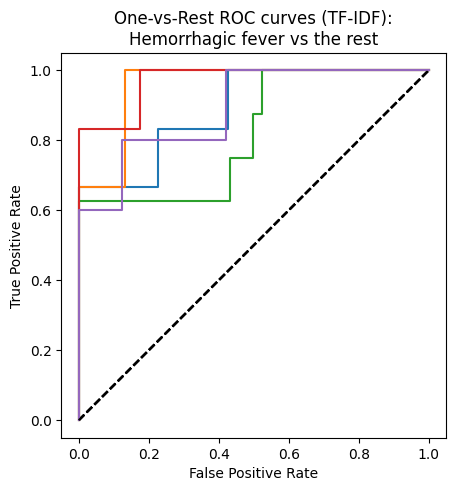

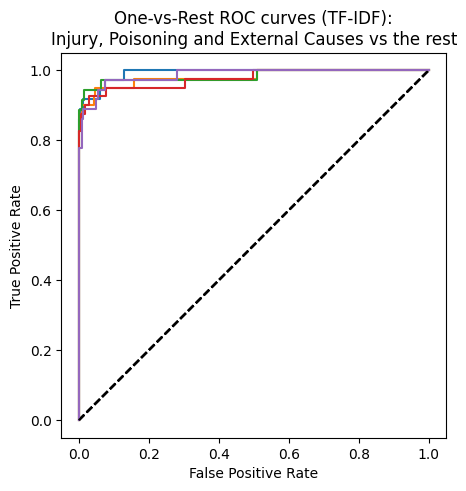

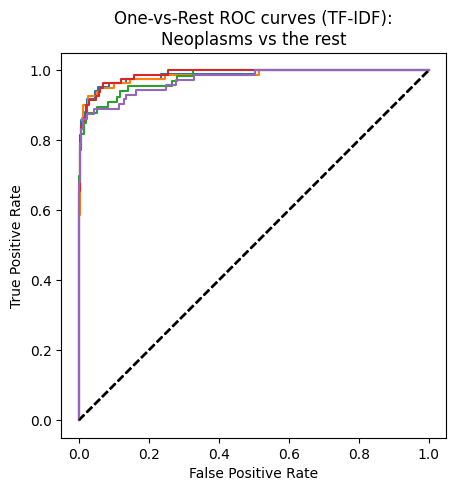

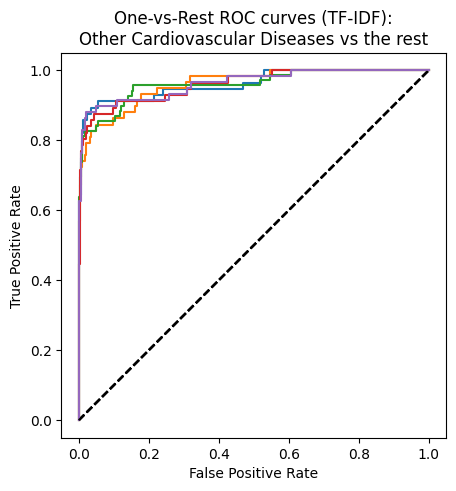

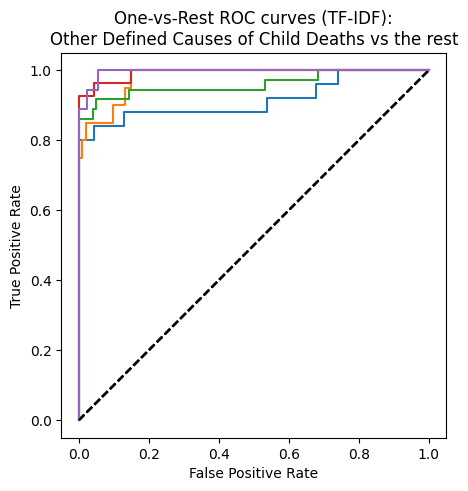

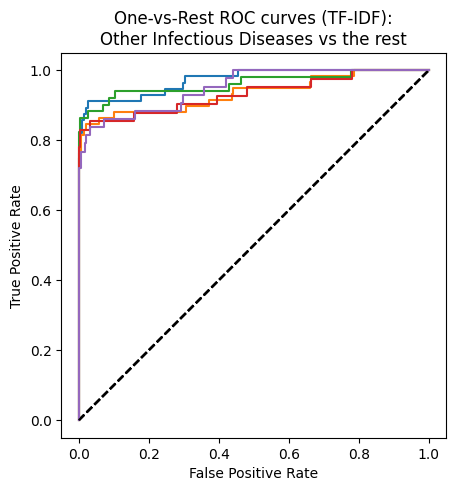

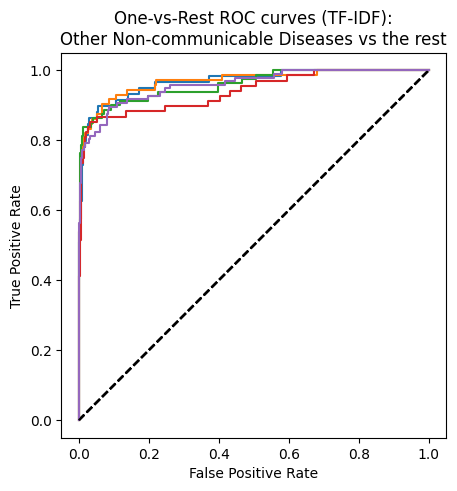

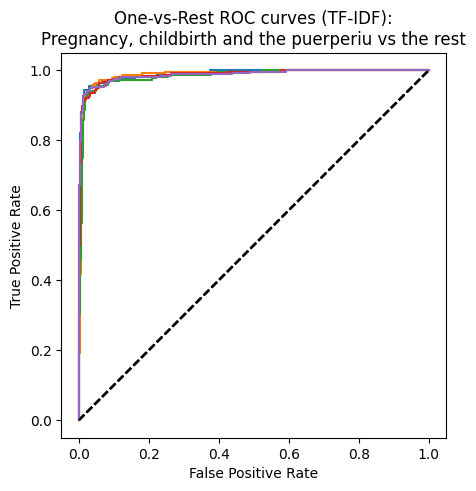

In [84]:
i = 0
for label in np.unique(labelsTF):
    plt.figure(i)
    i = i + 1
    for fpr, tpr, roc_auc in zip(fpr_list[label], tpr_list[label], roc_auc_list[label]):
        plt.plot(fpr,tpr,label="MLP tf-idf, AUC="+str(roc_auc))
        plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
        plt.axis("square")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("One-vs-Rest ROC curves (TF-IDF):\n" + label + " vs the rest")
        plt.savefig("data_graphics/ROC_tfidf/" + label + ".png")

In [85]:
from numpy import mean

print("La media del accuracy del MLP final utilizando TF-IDF: %f"%(mean(TF_final_mlp_scores)))

La media del accuracy del MLP final utilizando TF-IDF: 0.858989


<hr>

<h2>MLP: doc2vec vs TF-IDF</h2>

<h3>MLP por defecto (básico)</h3>

In [86]:
if mean(TF_basic_mlp_scores) > mean(DE_basic_mlp_scores):
    print("TF-IDF ha logrado mejor accuracy en el MLP básico con una diferencia de %f" %(mean(TF_basic_mlp_scores)-mean(DE_basic_mlp_scores)))
elif mean(TF_basic_mlp_scores) < mean(DE_basic_mlp_scores):
    print("doc2vec ha logrado mejor accuracy en el MLP básico con una diferencia de %f" %(mean(DE_basic_mlp_scores)-mean(TF_basic_mlp_scores)))
else:
    print("doc2vec y TF-IDF han logrado el mismo accuracy en el MLP básico")   

TF-IDF ha logrado mejor accuracy en el MLP básico con una diferencia de 0.140883


<h3>MLP final</h3>

In [87]:
if mean(TF_final_mlp_scores) > mean(DE_final_mlp_scores):
    print("TF-IDF ha logrado mejor accuracy en el MLP final con una diferencia de %f" %(mean(TF_final_mlp_scores)-mean(DE_final_mlp_scores)))
elif mean(TF_final_mlp_scores) < mean(DE_final_mlp_scores):
    print("doc2vec ha logrado mejor accuracy en el MLP final con una diferencia de %f" %(mean(DE_final_mlp_scores)-mean(TF_final_mlp_scores)))
else:
    print("doc2vec y TF-IDF han logrado el mismo accuracy en el MLP final")   

TF-IDF ha logrado mejor accuracy en el MLP final con una diferencia de 0.453615
